# Predicting Basketball Games Using Statistics

### Uriel Eckmann

![Lebron Dunk](../assets/lebron_dunk.png)

## Problem Statement

Basketball is an incredible game. It changes from year to year as teams develop new offensive schemes, and players develop incredible skills to get an edge over their opponents. As such, data analytics and data science can help players and coaches develop ways to adjust their gameplan to be unique to every single opponent, as well as help players determine what skills they should be focusing on. Simultaneously, predicting the outcomes of NBA games is a huge business, and the data from individual games can be used to predict the outcomes of upcoming matchups between two teams. So, we're looking to answer 2 questions here.
1. Can we use data to determine what parts of the game are most important?
2. Can we build a useful classification model that can accurately determine the outcomes of games?

In a certain sense, every game is a toss up. Each team has a 50/50 shot of winning the game. That's not necessarily the reality, but that does tell us what we're searching for when it comes to the success of our models - if our models can predict game winners with more the 50% accuracy. 

## Executive Summary

Our goal here is to create an accurate model that will predict game winners using data from previous games as well the game itself after the fact. 
### _Workflow_
#### _Data Collection_
The data for this project was collected from [Basketball-reference.com](https://www.basketball-reference.com/). This is a database of every professional game going back more than 50 years worth of data. Because I wanted to focus on how the modern game is approached, I utilized data from the 2017 - 2018 and 2018 - 2019 seasons. In order to collect this data, [I built three custom webscrapers]("./capstone_data_collection_webscraper.ipynb") designed to be able to collect entire seasons' worth of data at time. This was broken down into 4 parts:
1. The webscraper that collected [regular season standings](https://www.basketball-reference.com/leagues/NBA_2019.html). This webpage has a table of all 30 teams and their standings over the course of the season. This contained valuable information, which helped to build the next webscraper, 
2. The webscraper that collected [individual team schedules](https://www.basketball-reference.com/teams/MIL/2019_games.html). This webpage has a table with all 82 games for a team in any given season. This table provided more valuable information, such as game results, opponents, and the date of each game. This information then helped with the final webscraper,
3. The webscraper that collected [individual player and team statistics](https://www.basketball-reference.com/boxscores/201810170CHO.html) from every game. This included statistics from both teams, and had over 30 different relevant statistics for every individual player who played in that game.
4. The final piece was a function that used all 3 webscrapers to collect data from all 1,230 games of the regular season. These webscrapers can work on any season, all they need is for the user to specify what season they want data from. It is important to note that this function has a built in timer that slows down the webscrape, since basketball reference is providing a free service for us. 

#### _Data Exploration_
After collecting our data, we were able to investigate all of the different statistics and determine which of these will be most useful for our investigations. Our models are going to be using _team_ data, so it's important to recognize how individual player statistics are aggregated for the team, and which statistics will be most important. It should be noted that basketball is a game of points - it doesn't matter if you win by 1 or by 50. As such, that data can interfere with our models, since if one team's point totals are greater than  their opponents, our models will be able to infer who will win with that. We want to avoid all data leakage, so our models predicting games that are already over will highlight the other aspects of the game besides scoring points. This also includes team aggregates that are based on points, such as offensive and defensive rating. Additionally, there was the Box Plus/Minus stat, which only considers individual players, and is not applied to team play. Exploring how best to apply that stat to team overall performance was quite the challenge.

#### _Observations_
After building several models from our data, one thing has become clear - defense may be more important than offense. The phrase "The best defense is a good offense" is very true, because it doesn't matter how many points you score if your opponent outscores you. Our models highlighted how bad defense can be more impactful than a good offense. Our models that utilized data from earlier games also picked up on which teams are the best teams in recent years, giving them more weight as being winning teams. 

#### _Issues_
Building a custom webscrape was extremely arduous, and created a whole number of challenges. Working with the blend of Python and HTML was really interesting, and I had never built a webscraper with such intricate detail like that before. Additionally, the nature of our data made organizing it for modeling quite the challenge. Each row had to be matched up with the proper opponent, and each row had to be repeated- once with the home team first, then again with the away team first. 

## Table of Contents

### Contents:
- [Loading Packages and Data](#Loading-Packages-and-Data)
    - [Packages](#Packages)
    - [Data](#Data)
- [Data Dictionary](#Data-Dictionary)
- [Data Cleaning](#Data-Cleaning)
    - [Renaming Columns](#Renaming-Columns)
    - [Data Types](#Data-Types)
    - [Converting Data Types](#Converting-Data-Types)
        - [Minutes Played Column](#Minutes-Played-Column)
        - [Date Column](#Date-Column)
    - [Duplicate Columns](#Duplicate-Columns)
    - [Handling Nulls](#Handling-Nulls)
        - [Overtime](#Overtime)
        - [Field Goal, 3 - Point, and Free Throw Percentages](#Field-Goal,-3---Point,-and-Free-Throw-Percentages)
        - [Offensive and Defensive Ratings](#Offensive-and-Defensive-Ratings)
        - [Effective Field Goal Percentage, 3-Point Attempt Rate, and Free Throw Attempt Rate](#Effective-Field-Goal-Percentage,-3-Point-Attempt-Rate,-and-Free-Throw-Attempt-Rate)
        - [Turnover Percentage](#Turnover-Percentage)
        - [True Shooting Percentage](#True-Shooting-Percentage)
        - [Assist Percentage](#Assist-Percentage)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)

- [Model Preparation](#Model-Preparation)
   - [Convert Target Value to Binary](#Convert-Target-to-Binary)
   - [Model Workflow](#Model-Workflow)
   - [Train/Test Split](#Train/Test-Split)
   - [Model Evaluator](#Model-Evaluator)
- [Modeling](#Modeling)
    - [Baseline Model](#Baseline-Model)
    - [Multinomial Bayes Model](#Multinomial-Bayes-Models)
    - [Logistic Regressions](#Logistic-Regressions)

    - [Decision Trees](#Decision-Trees)

- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
    - [Confusion Matrix](#Confusion-Matrix)
    - [Coefficients and Interpretation](#Coefficients-and-Interpretation)
    - [Visualizing Coefficients](#Visualizing-Coefficients)
    - [Misclassifications](#Misclassifications)
- [Conclusion](#Conclusion)
- [Recommendations](#Recommendations)
- [References](#References)

## Loading Packages and Data

### Packages
These packages will allow us to access and model our data.

In [805]:
# Import libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

RANDOM_STATE = 613
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, roc_auc_score, plot_roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB

### Data
Our data is 2,460 games worth of data from the last 2 NBA regular seasons. 

In [428]:
# import our webscraped data
df = pd.read_csv('../data/teams_csv')
print (f'Our data has {df.shape[0]} rows and {df.shape[1]} columns.')
df.head()

Our data has 114254 rows and 43 columns.


,Season,Time Period,Date,Team,Team Abbreviation,Location,Overtime,Result,Player,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,TS%,eFG%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,BPM
0,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,NaN,W,DeMar DeRozan,32:03,2,9,0.222,0,0,NaN,7,8,0.875,1,5,6,5,2,1,5,1,11,0.439,0.222,0.000,0.889,3.6,16.3,10.2,20.8,3.0,2.6,28.5,23.4,86.0,97.0,-5.3
1,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,NaN,W,Kyle Lowry,31:20,4,7,0.571,1,3,0.333,3,3,1.000,0,4,4,9,1,0,4,1,12,0.721,0.643,0.429,0.429,0.0,13.3,7.0,41.9,1.5,0.0,32.5,16.8,121.0,103.0,2.3
2,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,NaN,W,Jonas Valančiūnas,30:30,9,17,0.529,0,1,0.000,5,6,0.833,8,7,15,2,2,0,1,4,23,0.586,0.529,0.059,0.353,30.0,23.9,26.8,12.7,3.2,0.0,4.8,28.9,136.0,96.0,4.3
3,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,NaN,W,Norman Powell,24:35,5,11,0.455,3,6,0.500,2,2,1.000,0,4,4,1,1,0,2,2,15,0.631,0.591,0.545,0.182,0.0,17.0,8.9,6.7,2.0,0.0,14.4,24.1,111.0,101.0,0.0
4,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,NaN,W,Serge Ibaka,24:14,3,8,0.375,2,4,0.500,0,0,NaN,1,3,4,0,0,2,0,2,8,0.500,0.500,0.500,0.000,4.7,12.9,9.0,0.0,0.0,7.0,0.0,14.1,113.0,101.0,-2.0


## Data Dictionary

This data dictionary provides information for every column in the dataset.

|Column Name|Data Type|Description|
|:---|:---|:---|
|Season |int |The year of that particular season|
|Time Period |object|Differentiates if a game was played during the regular season or during the playoffs|
|Date |Datetime|The date the game was played|
|Team |object|The team name|
|Team Abbreviation |object|The 3 letter abbreviation used for that team|
|Location |object|The relative location of where the team played, either `Home` or `Away`|
|Overtime |object|How many extra periods were required until there was a winner|
|Result |object|The result for each team, either `W` for win, or `L` for loss|
|Player |object|The name of the player on the team. `Team Totals` for the team's aggregated statistics|
|MP |object|The total minutes a player was on the court|
|FG |int|The number of baskets made. This includes 3-pointers|
|FGA |int|The number of baskets attempted. This includes 3-pointers|
|FG% |float|The number of baskets made divided by the number attempted. This includes 3-pointers|
|3P |int|The number of 3-point baskets made|
|3PA |int|The number of 3-point baskets attempted|
|3P% |float|The number of 3-point baskets made divided by the number of 3-pointers attempted|
|FT |int|The number of Free Throws made|
|FTA |int|The number of Free Throws attempted|
|FT% |float|The number of Free Throws made divided by the number of Free Throws attempted|
|ORB |int|The number of offensive rebounds|
|DRB  | int | the number of defensive rebounds
|TRB  | int | the total number of rebounds made
|AST  | int | the number of assists
|STL  | int | the number of steals
|BLK  | int | the number of blocks
|TOV  | int | the number of turnovers
|PF   | int | the number of personal fouls
|PTS  | int | the number of points
|TS%  | float | `True Shooting Percentage` a measure of shooting efficiency that takes 3-pointers, field goals, and free throws into account
|eFG% | float | `Effective Field Goal Percentage` a weighted version of field goal percentage that take 3-pointers into account
|3PAr | float | `3 Point Attempt Rate` the rate in which a player shoots 3 pointers. 3PA divided by FGA
|FTr  | float | `Free Throw Attempt Rate` the rate at which a player is fouled per shot attempt. FTA divided by FGA
|ORB% | float | `Offensive Rebound Percentage` - an estimate of the percentage of available offensive rebounds a player grabbed while he was on the floor
|DRB% | float | `Defensive Rebound Percentage` - an estimate of the percentage of available defensive rebounds a player grabbed while he was on the floor
|TRB% | float | `Total Rebound Percentage` - an estimate of the percentage of available rebounds a player grabbed while he was on the floor
|AST% | float | `Assist Percentage` - an estimate of the percentage of teammate field goals a player assisted while he was on the floor
|STL% | float | `Steal Percentage` - an estimate of the percentage of opponent possessions that end with a steal by the player while he was on the floor
|BLK% | float | `Block Percentage` - an estimate of the percentage of opponent two-point field goal attempts blocked by the player while he was on the floor
|TOV% | float | `Turnover Percentage` is an estimate of turnovers per 100 plays
|USG% | float |`Usage Percentage` - an estimate of the percentage of team plays used by a player while he was on the floor
|ORtg | float |  `Offensive Rating` - an estimate of points produced per 100 plays. An explanation can be found [here](https://www.basketball-reference.com/about/ratings.html)
|DRtg | float | `Defensive Rating` - an estimate of points allowed per 100 plays. An explanation can be found [here](https://www.basketball-reference.com/about/ratings.html)
|BPM  | float | `Box Plus/Minus` - a box score estimate of the points per 100 possessions that a player contributed above a league-average player. an explanation can be found [here](https://www.basketball-reference.com/about/bpm2.html)

## Data Cleaning

First, let's look at how many games were played in the regular season from 2017 - 2019. Each team plays 82 games a season. Each game was recorded twice, once from each team's perspective. That means each game is mentioned twice, equating to 164. We have 2 seasons worth of data, and 30 teams. if everything went right, there should be 9,840 games, which is 4 times the actual amount (2 teams per game, each game mentioned twice)

In [959]:
# start at zero and add each game
num_games = 0
# iterate through all 30 teams
for team in list(df["Team"].unique()):
    # add 1 for each time the team is mentioned, and only include the team totals row or our numbers will be off
    num_games += df.loc[(df["Team"] == team) &
                        (df["Player"] == "Team Totals"), "Player"].count()

# If everything went right, num_games should equal 9,840, 
if num_games  != 9840:
    print ("Something went wrong.")
else:
    print ("All games collected!")

message = (
    f'From the {df["Season"][0]} NBA season through the {df["Season"][df.shape[0]-1]} season, there were a total of '
    f'{int(num_games/4)} games played during the regular seasons.' 
)

print (message)

All games collected!
From the 2018 NBA season through the 2019 season, there were a total of 1230 games played during the regular seasons.


### Renaming Columns
These different statistics terms aren't exactly human readable. Lets convert them into something a bit more user-friendly.

In [431]:
df.rename(columns = {
    "TS%"  : "True Shooting Percentage",
    "eFG%" : "Effective Field Goal Percentage",
    "3PAr" : "3 Point Attempt Rate",
    "FTr"  : "Free Throw Attempt Rate",
    "ORB%" : "Offensive Rebound Percentage",
    "DRB%" : "Defensive Rebound Percentage",
    "TRB%" : "Total Rebound Percentage",
    "AST%" : "Assist Percentage",
    "STL%" : "Steal Percentage",
    "BLK%" : "Block Percentage",
    "TOV%" : "Turnover Percentage",
    "USG%" : "Usage Percentage",
    "ORtg" : "Offensive Rating",
    "DRtg" : "Defensive Rating",
    "BPM"  : "Box Plus/Minus",
    "MP"   : "Minutes Played",
    "FG"   : "Field Goals",
    "FGA"  : "Field Goal Attempts",
    "FG%"  : "Field Goal Percentage",
    "3P"   : "3-Point Field Goals",
    "3PA"  : "3-Point Attempts",
    "3P%"  : "3-Point Percentage",
    "FT"   : "Free Throws",
    "FTA"  : "Free Throw Attempts",
    "FT%"  : "Free Throw Percentage",
    "ORB"  : "Offensive Rebounds",
    "DRB"  : "Defensive Rebounds",
    "TRB"  : "Total Rebounds",
    "AST"  : "Assists",
    "STL"  : "Steals",
    "BLK"  : "Blocks",
    "TOV"  : "Turnovers",
    "PF"   : "Personal Fouls",
    "PTS"  : "Points"
    }, inplace = True)
df.head()

,Season,Time Period,Date,Team,Team Abbreviation,Location,Overtime,Result,Player,Minutes Played,Field Goals,Field Goal Attempts,Field Goal Percentage,3-Point Field Goals,3-Point Attempts,3-Point Percentage,Free Throws,Free Throw Attempts,Free Throw Percentage,Offensive Rebounds,Defensive Rebounds,Total Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,True Shooting Percentage,Effective Field Goal Percentage,3 Point Attempt Rate,Free Throw Attempt Rate,Offensive Rebound Percentage,Defensive Rebound Percentage,Total Rebound Percentage,Assist Percentage,Steal Percentage,Block Percentage,Turnover Percentage,Usage Percentage,Offensive Rating,Defensive Rating,Box Plus/Minus
0,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,NaN,W,DeMar DeRozan,32:03,2,9,0.222,0,0,NaN,7,8,0.875,1,5,6,5,2,1,5,1,11,0.439,0.222,0.000,0.889,3.6,16.3,10.2,20.8,3.0,2.6,28.5,23.4,86.0,97.0,-5.3
1,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,NaN,W,Kyle Lowry,31:20,4,7,0.571,1,3,0.333,3,3,1.000,0,4,4,9,1,0,4,1,12,0.721,0.643,0.429,0.429,0.0,13.3,7.0,41.9,1.5,0.0,32.5,16.8,121.0,103.0,2.3
2,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,NaN,W,Jonas Valančiūnas,30:30,9,17,0.529,0,1,0.000,5,6,0.833,8,7,15,2,2,0,1,4,23,0.586,0.529,0.059,0.353,30.0,23.9,26.8,12.7,3.2,0.0,4.8,28.9,136.0,96.0,4.3
3,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,NaN,W,Norman Powell,24:35,5,11,0.455,3,6,0.500,2,2,1.000,0,4,4,1,1,0,2,2,15,0.631,0.591,0.545,0.182,0.0,17.0,8.9,6.7,2.0,0.0,14.4,24.1,111.0,101.0,0.0
4,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,NaN,W,Serge Ibaka,24:14,3,8,0.375,2,4,0.500,0,0,NaN,1,3,4,0,0,2,0,2,8,0.500,0.500,0.500,0.000,4.7,12.9,9.0,0.0,0.0,7.0,0.0,14.1,113.0,101.0,-2.0


### Data Types
Let's check to see if our data was loaded with the correct data types for each column.

In [956]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57113 entries, 0 to 57112
Data columns (total 41 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Season                           57113 non-null  int64         
 1   Time Period                      57113 non-null  object        
 2   Date                             57113 non-null  datetime64[ns]
 3   Team                             57113 non-null  object        
 4   Team Abbreviation                57113 non-null  object        
 5   Location                         57113 non-null  object        
 6   Overtime                         57113 non-null  float64       
 7   Result                           57113 non-null  object        
 8   Player                           57113 non-null  object        
 9   Minutes Played                   57113 non-null  float64       
 10  Field Goals                      57113 non-null  int64    

Almost all of our columns are in the correct format - however, there are some that need to be converted before we can move on.

### Converting Data Types  
#### Minutes Played Column

While almost all of our columns are in the correct format, I want to change the "Minutes Played" Column into a float type, and convert seconds into a decimal out of 100. So, if a player played for 3 minutes and 45 seconds, instead of recording it as "3:45", it will now be recorded as _$3.75$_

In [432]:
def convert_to_float(string):
    if ":" in string:
        mins, secs = string.split(":")
        secs = round(int(secs)/60, 2)
        mins = int(mins)
        time = float(mins + secs)
        return time
    return float(string)

In [433]:
df["Minutes Played"] = df["Minutes Played"].map(convert_to_float)
df["Minutes Played"].dtypes

dtype('float64')

#### Date Column
Our date column was loaded in as an `object` type. Let's convert it to a datetime object.

In [434]:
df["Date"] = pd.to_datetime(df["Date"])
df["Date"].dtypes

dtype('<M8[ns]')

### Duplicate Columns
Our webscraper collected each game twice - once from the perspective of the home team, and once from the perspective of the away team. This means that every row has a duplicate in the dataset somewhere. We're going to get rid of these duplicates to make things easier.

In [435]:
df.loc[(df["Date"] == '2017-10-19') & 
       (df["Team"] == "Toronto Raptors") &
       (df["Player"] == "Team Totals"), :]

,Season,Time Period,Date,Team,Team Abbreviation,Location,Overtime,Result,Player,Minutes Played,Field Goals,Field Goal Attempts,Field Goal Percentage,3-Point Field Goals,3-Point Attempts,3-Point Percentage,Free Throws,Free Throw Attempts,Free Throw Percentage,Offensive Rebounds,Defensive Rebounds,Total Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,True Shooting Percentage,Effective Field Goal Percentage,3 Point Attempt Rate,Free Throw Attempt Rate,Offensive Rebound Percentage,Defensive Rebound Percentage,Total Rebound Percentage,Assist Percentage,Steal Percentage,Block Percentage,Turnover Percentage,Usage Percentage,Offensive Rating,Defensive Rating,Box Plus/Minus
12,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,NaN,W,Team Totals,240.0,39,83,0.47,13,29,0.448,26,28,0.929,13,36,49,26,10,4,17,19,117,0.614,0.548,0.349,0.337,31.0,78.3,55.7,66.7,10.0,7.0,15.1,100.0,117.2,100.1,NaN
22891,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,NaN,W,Team Totals,240.0,39,83,0.47,13,29,0.448,26,28,0.929,13,36,49,26,10,4,17,19,117,0.614,0.548,0.349,0.337,31.0,78.3,55.7,66.7,10.0,7.0,15.1,100.0,117.2,100.1,NaN


In [436]:
df.drop_duplicates(inplace = True)
df.shape

(57127, 43)

### Handling Nulls

In [437]:
df.isna().sum()

Season                                 0
Time Period                            0
Date                                   0
Team                                   0
Team Abbreviation                      0
Location                               0
Overtime                           54326
Result                                 0
Player                                 0
Minutes Played                         0
Field Goals                            0
Field Goal Attempts                    0
Field Goal Percentage               2160
3-Point Field Goals                    0
3-Point Attempts                       0
3-Point Percentage                 13132
Free Throws                            0
Free Throw Attempts                    0
Free Throw Percentage              22526
Offensive Rebounds                     0
Defensive Rebounds                     0
Total Rebounds                         0
Assists                                0
Steals                                 0
Blocks          

#### Overtime
Most games don't require an extra period, so those columns are left as null. Let's fill them in and convert the column into something we can use.

In [438]:
df["Overtime"].value_counts()

OT     2434
2OT     279
3OT      65
4OT      23
Name: Overtime, dtype: int64

In [439]:
df["Overtime"] = df["Overtime"].map({"OT"  : 1,
                                     "2OT" : 2,
                                     "3OT" : 3,
                                     "4OT" : 4})

df.loc[df["Overtime"].isna(), "Overtime"] = 0
df.head()

,Season,Time Period,Date,Team,Team Abbreviation,Location,Overtime,Result,Player,Minutes Played,Field Goals,Field Goal Attempts,Field Goal Percentage,3-Point Field Goals,3-Point Attempts,3-Point Percentage,Free Throws,Free Throw Attempts,Free Throw Percentage,Offensive Rebounds,Defensive Rebounds,Total Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,True Shooting Percentage,Effective Field Goal Percentage,3 Point Attempt Rate,Free Throw Attempt Rate,Offensive Rebound Percentage,Defensive Rebound Percentage,Total Rebound Percentage,Assist Percentage,Steal Percentage,Block Percentage,Turnover Percentage,Usage Percentage,Offensive Rating,Defensive Rating,Box Plus/Minus
0,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,DeMar DeRozan,32.05,2,9,0.222,0,0,NaN,7,8,0.875,1,5,6,5,2,1,5,1,11,0.439,0.222,0.000,0.889,3.6,16.3,10.2,20.8,3.0,2.6,28.5,23.4,86.0,97.0,-5.3
1,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,Kyle Lowry,31.33,4,7,0.571,1,3,0.333,3,3,1.000,0,4,4,9,1,0,4,1,12,0.721,0.643,0.429,0.429,0.0,13.3,7.0,41.9,1.5,0.0,32.5,16.8,121.0,103.0,2.3
2,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,Jonas Valančiūnas,30.50,9,17,0.529,0,1,0.000,5,6,0.833,8,7,15,2,2,0,1,4,23,0.586,0.529,0.059,0.353,30.0,23.9,26.8,12.7,3.2,0.0,4.8,28.9,136.0,96.0,4.3
3,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,Norman Powell,24.58,5,11,0.455,3,6,0.500,2,2,1.000,0,4,4,1,1,0,2,2,15,0.631,0.591,0.545,0.182,0.0,17.0,8.9,6.7,2.0,0.0,14.4,24.1,111.0,101.0,0.0
4,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,Serge Ibaka,24.23,3,8,0.375,2,4,0.500,0,0,NaN,1,3,4,0,0,2,0,2,8,0.500,0.500,0.500,0.000,4.7,12.9,9.0,0.0,0.0,7.0,0.0,14.1,113.0,101.0,-2.0


In [440]:
df["Overtime"].value_counts()

0.0    54326
1.0     2434
2.0      279
3.0       65
4.0       23
Name: Overtime, dtype: int64

#### Field Goal, 3 - Point, and Free Throw Percentages
Since these columns are derived from made baskets and attempts, they're redundant, and we'll just drop them.

In [441]:
df.drop(columns = ["Field Goal Percentage","3-Point Percentage", "Free Throw Percentage"],
           inplace = True)

#### Offensive and Defensive Ratings
We have 14 rows where these and other values are null - let's look into this.

In [442]:
df.loc[df["Offensive Rating"].isna(), :]

,Season,Time Period,Date,Team,Team Abbreviation,Location,Overtime,Result,Player,Minutes Played,Field Goals,Field Goal Attempts,3-Point Field Goals,3-Point Attempts,Free Throws,Free Throw Attempts,Offensive Rebounds,Defensive Rebounds,Total Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,True Shooting Percentage,Effective Field Goal Percentage,3 Point Attempt Rate,Free Throw Attempt Rate,Offensive Rebound Percentage,Defensive Rebound Percentage,Total Rebound Percentage,Assist Percentage,Steal Percentage,Block Percentage,Turnover Percentage,Usage Percentage,Offensive Rating,Defensive Rating,Box Plus/Minus
2393,2018,Regular Season,2017-11-20,Dallas Mavericks,DAL,Home,1.0,L,Nerlens Noel,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.7
4017,2018,Regular Season,2017-10-28,Dallas Mavericks,DAL,Home,0.0,L,Salah Mejri,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.2
11055,2018,Regular Season,2018-03-12,Portland Trail Blazers,POR,Home,0.0,W,Jake Layman,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.7
15855,2018,Regular Season,2017-12-17,Detroit Pistons,DET,Home,0.0,W,Boban Marjanović,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11.0
19652,2018,Regular Season,2017-12-12,Los Angeles Lakers,LAL,Away,1.0,L,Andrew Bogut,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.8
46937,2018,Regular Season,2018-02-05,Los Angeles Clippers,LAC,Home,0.0,W,Boban Marjanović,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.8
46948,2018,Regular Season,2018-02-05,Dallas Mavericks,DAL,Away,0.0,L,Jalen Jones,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.3
57429,2019,Regular Season,2018-11-10,Los Angeles Clippers,LAC,Home,1.0,W,Boban Marjanović,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.5
63363,2019,Regular Season,2018-12-01,Boston Celtics,BOS,Away,0.0,W,Robert Williams,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.5
64478,2019,Regular Season,2019-03-18,Denver Nuggets,DEN,Away,0.0,W,Jarred Vanderbilt,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.2


As we can see, these are rows with basically no information, so we can comfortably drop them from our dataset.

In [443]:
df.shape

(57127, 40)

In [444]:
df.drop(index= list(df.loc[df["Offensive Rating"].isna(), :].index), inplace = True)
df.reset_index(inplace = True, drop = True)
df.shape

(57113, 40)

#### Effective Field Goal Percentage, 3-Point Attempt Rate, and Free Throw Attempt Rate

##### Effective Field Goal Percentage
This statistic is designed to give more weight to 3 point shots given the fact that they're worth a whole extra point. As such, this statistic is calculated as:

$$eFG\% = \frac{Field \  Goals + (0.5 \cdot Three \ Pointers)}{Field \ Goal \ Attempts}$$

Keeping in mind that the Field Goals category includes Three Pointers. 

##### Free Throw Attempt Rate
This statistic checks to see what percentage of shots taken were three pointers:

$$Three \ Point \ Attempt \ Rate = \frac{Three \ Point \ Attempts}{Field \ Goal \ Attempts}$$

##### 3-Point Attempt Rate
This statistic checks to see what percentage of shot attempts resulted in free throws:

$$Free \ Throw \ Attempt \ Rate = \frac{Free \ Throw \ Attempts}{Field \ Goal \ Attempts}$$


Given these statistics, because there are certain instances where players will be on the court and not take any shots, since we can't divide by 0, these statistics are filled in with Null values. As such, these players just don't affect overall team performance in these statistics. As such, we'll leave them in as they are. It is worth checking to ensure there are no circumstances where the whole team has this value as a null.

In [445]:
df.loc[(df["Effective Field Goal Percentage"].isna()) &
       (df["3 Point Attempt Rate"].isna()) &
       (df["Free Throw Attempt Rate"].isna()) &
       (df["Player"] == "Team Totals"), :].sum().sum()

0.0

#### Turnover Percentage

Turnover percentage is an estimate as to how many turnovers the team would make in 100 possessions, which is roughly the amount each team has in one 48 minute game. As such, Turnover Percentage can often be very close to the actual number of turnovers for a team. It is derived as such:

$$Turnover \ Percentage = 100 \cdot \frac{Turnovers}{Field \ Goal\ Attempts + \ (0.44 \cdot Free\ Throw \ Attempts) + Turnovers}$$

Given how many players did not attempt any shots, it's no surprise that from among them, most of them had no turnovers or free throw attempts either. Since we cannot divide by zero, these values are given nulls. They do not effect overall team turnover percentage, as that is calculated in the same way, using the team totals for all the values. 

#### True Shooting Percentage

True shooting percentage is a measure of shooting efficiency that takes into account field goals, 3-point field goals, and free throws. It is calculated as:

$$ True \ Shooting \ Percentage = \frac{Points}{2 \cdot True \ Shooting \ Attempts}$$

What then, are True shooting attempts? A measurement of all shooting attempts, including Free Throws. It is calculated as:  

$$ True Shooting Attempts =  Field \ Goal \ Attempts + (0.44 \cdot Free \ Throw \ Attempts)$$

So, we can rewrite True Shooting Percentage as:

$$ True \ Shooting \ Percentage = \frac{Points}{2 \cdot (Field \ Goal \ Attempts + (0.44 \cdot Free \ Throw \ Attempts))}$$

Given this information, there are plenty of players who play in a game and take no field goal attempts or free throw attempts. As such, their percentages for this stat are null. This in no way effects the team percentage which uses the same calculation. 

#### Assist Percentage
Assist Percentage is an estimate of the percentage of teammate field goals a player assisted while he was on the floor. It is calculated as:

$$Assist \ Percentage = 100 \ \cdot \ \frac{Assists}{(\frac{Minutes \ Played}{\frac{Team \ Minutes \ Played}{5}} \cdot Team \ Field \ Goals) - Field \ Goals}$$

In [446]:
df.loc[df["Assist Percentage"].isna(), :]

,Season,Time Period,Date,Team,Team Abbreviation,Location,Overtime,Result,Player,Minutes Played,Field Goals,Field Goal Attempts,3-Point Field Goals,3-Point Attempts,Free Throws,Free Throw Attempts,Offensive Rebounds,Defensive Rebounds,Total Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,True Shooting Percentage,Effective Field Goal Percentage,3 Point Attempt Rate,Free Throw Attempt Rate,Offensive Rebound Percentage,Defensive Rebound Percentage,Total Rebound Percentage,Assist Percentage,Steal Percentage,Block Percentage,Turnover Percentage,Usage Percentage,Offensive Rating,Defensive Rating,Box Plus/Minus
41705,2019,Regular Season,2018-12-05,Charlotte Hornets,CHO,Away,0.0,L,Devonte' Graham,2.4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1.0,1.0,0.0,0.0,37.7,54.1,44.4,NaN,0.0,0.0,0.0,34.9,204.0,118.0,38.7


Our one instance of having a null value for assist percentage actually comes from a strange set of  circumstances. Given the nature of the way assist percentage is calculated, it should seem almost impossible for the denominator to equal zero. However, in this circumstance, the stars aligned, and it worked out perfectly. Due to an issue in how stats can be aligned sometimes on Basketball-Reference, the player who had the null value here is _actually_ Willy Hernangómez, a teammate of Devonte' Graham's, whose stats aligned in this game from December 5, 2018. If we calculate just the denominator of assist percentages, we'll get zero in this circumstance. Willy played for 2.4 minutes and had 2 field goals. The team played a total of 240 minutes, and had 40 field goals.
$$Denominator =  (\frac{Minutes \ Played}{\frac{Team \ Minutes \ Played}{5}} \cdot Team \ Field \ Goals) - Field \ Goals = (\frac{2.4}{\frac{240}{5}} \cdot 40) - 2 = (\frac{2.4}{48} \cdot 40) - 2 = \frac{96}{48} - 2 = 2 - 2 =0 $$

As such, we won't drop this column - we'll just leave it be, as it doesn't affect the team totals.

## Exploratory Data Analysis

In [96]:
df.describe()

,Season,Overtime,Minutes Played,Field Goals,Field Goal Attempts,3-Point Field Goals,3-Point Attempts,Free Throws,Free Throw Attempts,Offensive Rebounds,Defensive Rebounds,Total Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,True Shooting Percentage,Effective Field Goal Percentage,3 Point Attempt Rate,Free Throw Attempt Rate,Offensive Rebound Percentage,Defensive Rebound Percentage,Total Rebound Percentage,Assist Percentage,Steal Percentage,Block Percentage,Turnover Percentage,Usage Percentage,Offensive Rating,Defensive Rating,Box Plus/Minus
count,57113.000000,57113.000000,57113.000000,57113.000000,57113.000000,57113.000000,57113.000000,57113.000000,57113.000000,57113.000000,57113.000000,57113.000000,57113.000000,57113.000000,57113.000000,57113.000000,57113.000000,57113.000000,55223.000000,54967.000000,54967.000000,54967.000000,57113.000000,57113.000000,57113.000000,57112.000000,57113.000000,57113.000000,55555.000000,57113.000000,57113.000000,57113.000000,52193.000000
mean,2018.499956,0.057342,41.612182,6.951027,15.098734,1.882654,5.255616,2.955439,3.854919,1.727978,5.911579,7.639557,4.119763,1.322343,0.841525,2.343950,3.511004,18.740147,0.540455,0.509676,0.355260,0.275404,6.165201,20.641458,13.420393,17.664305,2.033905,2.315806,12.542959,26.031986,105.238385,110.419185,-1.254718
std,0.500004,0.274749,62.188224,10.772282,23.021447,3.252510,8.469025,5.162704,6.612392,3.055602,9.253796,11.917659,6.701274,2.324735,1.643989,3.868997,5.509961,28.969811,0.244534,0.256531,0.270993,0.405024,8.793853,21.138660,13.564914,19.437856,2.952321,4.109718,13.721749,24.218290,44.540748,13.102969,13.056585
min,2018.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-84.000000,-1000.000000
25%,2018.000000,0.000000,16.450000,2.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,4.000000,0.417000,0.375000,0.143000,0.000000,0.000000,7.300000,5.000000,3.700000,0.000000,0.000000,0.000000,14.000000,84.000000,102.000000,-6.900000
50%,2018.000000,0.000000,24.970000,4.000000,8.000000,1.000000,3.000000,1.000000,2.000000,1.000000,3.000000,4.000000,2.000000,1.000000,0.000000,1.000000,2.000000,10.000000,0.549000,0.500000,0.333000,0.182000,3.200000,14.700000,9.400000,12.200000,1.300000,0.000000,10.700000,19.500000,108.000000,111.000000,-1.000000
75%,2019.000000,0.000000,33.000000,7.000000,13.000000,2.000000,5.000000,3.000000,4.000000,2.000000,6.000000,7.000000,4.000000,1.000000,1.000000,2.000000,3.000000,18.000000,0.670000,0.650000,0.500000,0.376000,9.000000,25.100000,16.200000,25.200000,3.000000,3.600000,18.200000,26.500000,128.000000,119.000000,4.800000
max,2019.000000,4.000000,340.000000,61.000000,123.000000,27.000000,70.000000,44.000000,64.000000,26.000000,56.000000,71.000000,46.000000,20.000000,19.000000,29.000000,42.000000,168.000000,1.500000,1.500000,1.000000,8.000000,100.000000,100.000000,100.000000,100.000000,94.400000,100.000000,100.000000,100.000000,300.000000,159.000000,517.400000


#### Box Plus/Minus

In [447]:
df["Box Plus/Minus"].describe()

count    52193.000000
mean        -1.254718
std         13.056585
min      -1000.000000
25%         -6.900000
50%         -1.000000
75%          4.800000
max        517.400000
Name: Box Plus/Minus, dtype: float64

In [448]:
df.loc[(df["Box Plus/Minus"] < -100) |
       (df["Box Plus/Minus"] > 100), :]

,Season,Time Period,Date,Team,Team Abbreviation,Location,Overtime,Result,Player,Minutes Played,Field Goals,Field Goal Attempts,3-Point Field Goals,3-Point Attempts,Free Throws,Free Throw Attempts,Offensive Rebounds,Defensive Rebounds,Total Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,True Shooting Percentage,Effective Field Goal Percentage,3 Point Attempt Rate,Free Throw Attempt Rate,Offensive Rebound Percentage,Defensive Rebound Percentage,Total Rebound Percentage,Assist Percentage,Steal Percentage,Block Percentage,Turnover Percentage,Usage Percentage,Offensive Rating,Defensive Rating,Box Plus/Minus
1815,2018,Regular Season,2018-03-31,Boston Celtics,BOS,Home,0.0,W,Xavier Silas,0.17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,113.0,-111.3
4958,2018,Regular Season,2018-03-01,Cleveland Cavaliers,CLE,Home,0.0,L,London Perrantes,0.20,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0.000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,123.0,-204.2
5487,2018,Regular Season,2017-10-20,Cleveland Cavaliers,CLE,Away,0.0,W,Channing Frye,1.23,1,1,1,1,0,0,0,1,1,1,0,0,0,0,3,1.500,1.5,1.0,0.0,0.0,90.5,52.6,100.0,0.0,0.0,0.0,36.9,282.0,93.0,122.6
10288,2018,Regular Season,2017-11-10,San Antonio Spurs,SAS,Home,0.0,L,Dāvis Bertāns,0.25,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0.000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,110.0,-151.7
10880,2018,Regular Season,2018-01-26,Milwaukee Bucks,MIL,Home,0.0,W,D.J. Wilson,0.82,1,1,1,1,0,0,0,0,0,0,0,0,0,0,3,1.500,1.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.3,300.0,105.0,114.2
19079,2018,Regular Season,2017-12-23,Dallas Mavericks,DAL,Away,0.0,L,Kyle Collinsworth,0.02,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,10.0,-1000.0
22958,2018,Regular Season,2017-10-21,Oklahoma City Thunder,OKC,Away,0.0,L,Josh Huestis,1.53,1,1,1,1,0,0,0,0,0,0,1,0,0,0,3,1.500,1.5,1.0,0.0,0.0,0.0,0.0,0.0,33.7,0.0,0.0,30.3,300.0,39.0,105.1
24169,2018,Regular Season,2017-12-26,Utah Jazz,UTA,Away,0.0,L,Naz Mitrou-Long,0.52,1,1,1,1,0,0,0,0,0,0,0,0,0,0,3,1.500,1.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.9,300.0,131.0,242.2
24180,2018,Regular Season,2017-12-26,Denver Nuggets,DEN,Home,0.0,W,Richard Jefferson,1.53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.434,1.5,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76.6,292.0,106.0,166.9
28247,2018,Regular Season,2018-02-13,Dallas Mavericks,DAL,Home,0.0,L,Jalen Jones,0.05,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,-35.0,-746.2


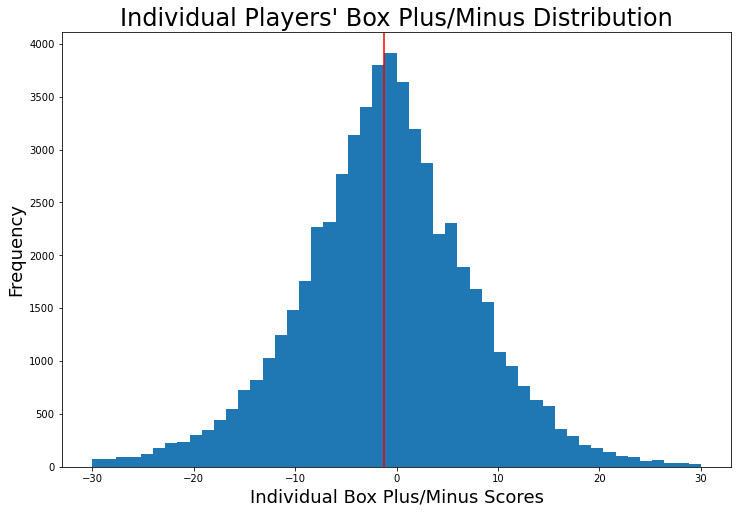

In [962]:
plt.figure(figsize = (12, 8))
plt.hist(df["Box Plus/Minus"],
        range = (-30,30),
        bins = 50)
plt.axvline(df.loc[df["Player"] != "Team Totals", "Box Plus/Minus"].mean(), color = 'red')
plt.title("Individual Players' Box Plus/Minus Distribution", fontsize = 24)
plt.xlabel("Individual Box Plus/Minus Scores", fontsize = 18)
plt.ylabel("Frequency", fontsize = 18);

__Interpretation:__

In [450]:
 def bpm_result(dates, column):
    games_list = []
    
    for date in dates:
    
        indecies = list(df.loc[(df["Date"] == date) & 
                       (df["Player"] == "Team Totals"), :].index)

        teams_played = []
        for i in range(0, len(indecies) -1):
            num = 0
            if indecies[i + 1] - indecies[i] < 20:
                teams_played.append((df.loc[indecies[i], "Team"], df.loc[indecies[i + 1], "Team"]))

        for opponents in teams_played:
            team1, team2 = opponents
            
            location_status = list(df.loc[(df["Date"] == date) &
                                  (df["Team"] == team1), :]["Location"])[0]
    
            if location_status == "Home":
                home_team = team1
            else:
                home_team = team2

            if home_team == team1:
                away_team = team2
            else:
                away_team = team1
                        
            game = df.loc[(df["Date"] == date) & (df["Team"] == home_team) | 
                          (df["Date"] == date) & (df["Team"] == away_team), :]

            # Get the result of win or loss for the home team
            home_team_result = list(game.loc[game["Team"] == home_team, :]["Result"])[0]

            # Get the total team points in the game for team 1
            home_team_points = list(game.loc[(game["Team"] == home_team) &
                                             (game["Player"] == "Team Totals"), "Points"])[0]

            # Get the total team points in the game for team2
            away_team_points = list(game.loc[(game["Team"] == away_team) &
                                             (game["Player"] == "Team Totals"), "Points"])[0]

            # Collect the average BPM for team 1 in that game
            home_team_avg_bpm = round(game.loc[(game["Team"] == home_team) & 
                                               (game["Player"] != "Team Totals"), :][column].mean(), 4)
            
            # Collect the average BPM for team 2 in that game
            away_team_avg_bpm = round(game.loc[(game["Team"] == away_team) & 
                                               (game["Player"] != "Team Totals"), :][column].mean(), 4)

            # Collect the sum BPM for team 1 in that game
            home_team_sum_bpm = round(game.loc[(game["Team"] == home_team) & 
                                               (game["Player"] != "Team Totals"), :][column].sum(), 4)
        
            # Collect the sum BPM for team 2 in that game
            away_team_sum_bpm = round(game.loc[(game["Team"] == away_team) & 
                                               (game["Player"] != "Team Totals"), :][column].sum(), 4)

            season = list(game["Season"])[0]

            avg_bpm_difference = home_team_avg_bpm - away_team_avg_bpm
            sum_bpm_difference = home_team_sum_bpm - away_team_sum_bpm
            point_differential = home_team_points  - away_team_points
            
            if column == "Box Plus/Minus":
                col_header = "BPM"
            elif column == "Adjusted Box Plus/Minus":
                col_header = "Adjusted BPM"

            cols = ["Season", "Date", "Home Team", "Home Team Average " + col_header, "Home Team Summed " + col_header,
                    "Home Team Total Points", "Away Team", "Away Team Average " + col_header, 
                    "Away Team Summed " + col_header, "Away Team Total Points",
                    "Home Team Average " + col_header + " Difference", 
                    "Home Team Summed " + col_header + " Difference", 
                    "Home Team Point Differential", "Home Team Result"]

            game_info = dict(zip(cols,[season, date, home_team , home_team_avg_bpm, home_team_sum_bpm, 
                                       home_team_points,  away_team, away_team_avg_bpm, 
                                       away_team_sum_bpm, away_team_points, avg_bpm_difference, 
                                       sum_bpm_difference, point_differential, home_team_result]))
                        
            games_list.append(game_info)
    
    games_df = pd.DataFrame(games_list)                    
                        
    return games_df

In [451]:
bpm_df = bpm_result(sorted(df["Date"].unique()), "Box Plus/Minus")
bpm_df.head()

,Season,Date,Home Team,Home Team Average BPM,Home Team Summed BPM,Home Team Total Points,Away Team,Away Team Average BPM,Away Team Summed BPM,Away Team Total Points,Home Team Average BPM Difference,Home Team Summed BPM Difference,Home Team Point Differential,Home Team Result
0,2018,2017-10-17,Cleveland Cavaliers,-1.240,-12.4,102,Boston Celtics,-2.720,-27.2,99,1.48,14.8,3,W
1,2018,2017-10-17,Golden State Warriors,1.825,21.9,121,Houston Rockets,2.125,17.0,122,-0.30,4.9,-1,L
2,2018,2017-10-18,Boston Celtics,-0.440,-4.4,100,Milwaukee Bucks,0.330,3.3,108,-0.77,-7.7,-8,L
3,2018,2017-10-18,Washington Wizards,-1.290,-12.9,120,Philadelphia 76ers,-1.510,-15.1,115,0.22,2.2,5,W
4,2018,2017-10-18,Indiana Pacers,-0.570,-5.7,140,Brooklyn Nets,-2.650,-26.5,131,2.08,20.8,9,W


In [452]:
print (f'There are {bpm_df.shape[0]} games in this dataframe.')

There are 2460 games in this dataframe.


In [453]:
def bpm_checker(dataframe, cols):
    final_df = pd.DataFrame()
    metrics_df = pd.DataFrame()
    
    for col in cols:
        
        better_bpm_with_win = dataframe.loc[(dataframe["Home Team Result"] == "W") &
                                         (dataframe[col] > 0), "Home Team Result"].count()

        better_bpm_with_loss = dataframe.loc[(dataframe["Home Team Result"] == "L") &
                                         (dataframe[col] > 0), "Home Team Result"].count()

        worse_bpm_with_win = dataframe.loc[(dataframe["Home Team Result"] == "W") &
                                         (dataframe[col] < 0), "Home Team Result"].count()

        worse_bpm_with_loss = dataframe.loc[(dataframe["Home Team Result"] == "L") &
                                         (dataframe[col] < 0), "Home Team Result"].count()

        bpm_accuracy = np.array([better_bpm_with_win, better_bpm_with_loss, worse_bpm_with_win, worse_bpm_with_loss])

        bpm_accuracy = bpm_accuracy.reshape(2, 2)
        
        aggregate_type = col.split(" ")[2]

        bpm_accuracy_df = pd.DataFrame(bpm_accuracy,
                                          index = [aggregate_type + " Better BPM", aggregate_type + " Worse BPM"],
                                          columns = ["Wins", "Losses"])

        final_df = final_df.append(bpm_accuracy_df)
  
        metrics_list = []
        metrics = ["Accuracy", "Sensitivity", "Specificity"]
        cm_accuracy = round(100 * (better_bpm_with_win + worse_bpm_with_loss)/dataframe.shape[0], 2)
        cm_sensitivity = round(100 * better_bpm_with_win/(better_bpm_with_win + worse_bpm_with_win), 2)
        cm_specificity = round(100 * worse_bpm_with_loss/(better_bpm_with_loss + worse_bpm_with_loss), 2)
        
        metrics_list.append(dict(zip(metrics, [cm_accuracy, cm_sensitivity, cm_specificity])))
        cm_metrics = pd.DataFrame(metrics_list,
                                  index = [aggregate_type + " Score"])
        
        metrics_df = metrics_df.append(cm_metrics)

    
    return final_df, metrics_df

In [454]:
team_bpm, bpm_metrics = bpm_checker(bpm_df, ["Home Team Average BPM Difference", "Home Team Summed BPM Difference"])
team_bpm

,Wins,Losses
Average Better BPM,1102,242
Average Worse BPM,339,776
Summed Better BPM,1085,243
Summed Worse BPM,354,775


In [455]:
bpm_metrics

,Accuracy,Sensitivity,Specificity
Average Score,76.34,76.47,76.23
Summed Score,75.61,75.40,76.13


From these 2 dataframes, we can see how using the average score for entire team could make for a better predictor when it comes to using the team average. As such, we'll impute that for all the null values for the team totals.

In [546]:
for date in list(df["Date"].unique()):

    teams = list(df.loc[(df["Date"] == date), "Team"].unique())
    for team in teams:
        df.loc[(df["Team"] == team) &
               (df["Date"] == date) &
               (df["Player"] == "Team Totals"), "Box Plus/Minus"] = round(df.loc[(df["Team"] == team) &
                                                                                 (df["Date"] == date) &
                                                                                 (df["Player"] != "Team Totals"), 
                                                                                 "Box Plus/Minus"].mean(), 2)

df.loc[df["Player"] == "Team Totals", :].head()

,Season,Time Period,Date,Team,Team Abbreviation,Location,Overtime,Result,Player,Minutes Played,Field Goals,Field Goal Attempts,3-Point Field Goals,3-Point Attempts,Free Throws,Free Throw Attempts,Offensive Rebounds,Defensive Rebounds,Total Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,True Shooting Percentage,Effective Field Goal Percentage,3 Point Attempt Rate,Free Throw Attempt Rate,Offensive Rebound Percentage,Defensive Rebound Percentage,Total Rebound Percentage,Assist Percentage,Steal Percentage,Block Percentage,Turnover Percentage,Usage Percentage,Offensive Rating,Defensive Rating,Box Plus/Minus,Adjusted Box Plus/Minus
12,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,Team Totals,240.0,39,83,13,29,26,28,13,36,49,26,10,4,17,19,117,0.614,0.548,0.349,0.337,31.0,78.3,55.7,66.7,10.0,7.0,15.1,100.0,117.2,100.1,0.66,NaN
25,2018,Regular Season,2017-10-19,Chicago Bulls,CHI,Away,0.0,L,Team Totals,240.0,37,89,10,32,16,18,10,29,39,22,7,2,19,23,100,0.516,0.472,0.360,0.202,21.7,69.0,44.3,59.5,7.0,3.7,16.4,100.0,100.1,117.2,-1.31,NaN
39,2018,Regular Season,2017-10-21,Toronto Raptors,TOR,Home,0.0,W,Team Totals,240.0,42,89,13,44,31,37,8,43,51,23,5,10,13,29,128,0.608,0.545,0.494,0.416,19.5,84.3,55.4,54.8,4.7,17.2,11.0,100.0,119.1,87.4,3.24,NaN
52,2018,Regular Season,2017-10-21,Philadelphia 76ers,PHI,Away,0.0,L,Team Totals,240.0,32,82,8,24,22,36,8,33,41,18,5,4,20,26,94,0.480,0.439,0.293,0.439,15.7,80.5,44.6,56.3,4.7,8.9,17.0,100.0,87.4,119.1,-4.36,NaN
63,2018,Regular Season,2017-10-23,Toronto Raptors,TOR,Away,0.0,L,Team Totals,240.0,34,80,10,37,19,24,5,29,34,17,11,4,14,30,97,0.536,0.488,0.463,0.300,11.9,61.7,38.2,50.0,11.2,5.7,13.4,100.0,98.8,102.8,1.03,NaN


In [581]:
df.loc[df["Player"] == "Team Totals", "Box Plus/Minus"].describe()

count    4920.000000
mean       -1.235982
std         3.394712
min       -91.850000
25%        -2.690000
50%        -1.180000
75%         0.280000
max        42.420000
Name: Box Plus/Minus, dtype: float64

In [595]:
df.loc[(df["Player"] == "Team Totals") &
       (df["Box Plus/Minus"] < -20) |
       (df["Player"] == "Team Totals") &
       (df["Box Plus/Minus"] > 20), :]

,Season,Time Period,Date,Team,Team Abbreviation,Location,Overtime,Result,Player,Minutes Played,Field Goals,Field Goal Attempts,3-Point Field Goals,3-Point Attempts,Free Throws,Free Throw Attempts,Offensive Rebounds,Defensive Rebounds,Total Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,True Shooting Percentage,Effective Field Goal Percentage,3 Point Attempt Rate,Free Throw Attempt Rate,Offensive Rebound Percentage,Defensive Rebound Percentage,Total Rebound Percentage,Assist Percentage,Steal Percentage,Block Percentage,Turnover Percentage,Usage Percentage,Offensive Rating,Defensive Rating,Box Plus/Minus
4959,2018,Regular Season,2018-03-01,Cleveland Cavaliers,CLE,Home,0.0,L,Team Totals,240.0,36,87,9,32,16,23,10,35,45,23,4,6,9,21,97,0.499,0.466,0.368,0.264,20.0,71.4,45.5,63.9,4.2,10.0,8.5,100.0,102.8,114.4,-21.17
19080,2018,Regular Season,2017-12-23,Dallas Mavericks,DAL,Away,0.0,L,Team Totals,240.0,43,85,9,33,12,15,7,23,30,31,8,3,10,17,107,0.584,0.559,0.388,0.176,17.9,79.3,44.1,72.1,8.7,5.9,9.8,100.0,116.0,121.5,-91.85
28248,2018,Regular Season,2018-02-13,Dallas Mavericks,DAL,Home,0.0,L,Team Totals,240.0,38,83,15,40,18,23,4,33,37,29,4,4,9,15,109,0.585,0.548,0.482,0.277,10.8,86.8,49.3,76.3,4.2,6.9,8.8,100.0,114.0,119.3,-65.44
31608,2019,Regular Season,2019-01-27,Dallas Mavericks,DAL,Home,0.0,L,Team Totals,240.0,43,88,11,36,23,34,7,36,43,25,5,2,11,29,120,0.583,0.551,0.409,0.386,16.3,81.8,49.4,58.1,5.0,4.1,9.7,100.0,119.4,122.4,42.42
38122,2019,Regular Season,2019-01-25,Brooklyn Nets,BRK,Home,0.0,W,Team Totals,240.0,34,84,9,33,32,47,18,42,60,19,5,2,19,21,109,0.521,0.458,0.393,0.560,40.0,87.5,64.5,55.9,5.0,3.6,15.4,100.0,109.5,99.4,27.95
40447,2019,Regular Season,2018-12-19,Minnesota Timberwolves,MIN,Home,1.0,L,Team Totals,265.0,45,103,9,33,24,29,11,38,49,22,8,4,7,27,123,0.531,0.481,0.320,0.282,23.4,82.6,52.7,48.9,7.4,8.7,5.7,100.0,113.7,119.3,-47.45
51191,2019,Regular Season,2019-03-07,Portland Trail Blazers,POR,Home,1.0,L,Team Totals,265.0,37,94,9,41,38,47,14,37,51,14,7,8,14,27,121,0.528,0.441,0.436,0.500,25.0,69.8,46.8,37.8,6.2,10.3,10.9,100.0,107.1,114.2,-81.60
53869,2019,Regular Season,2019-03-08,Oklahoma City Thunder,OKC,Away,0.0,L,Team Totals,240.0,41,102,11,44,17,26,14,38,52,20,3,7,11,34,110,0.485,0.456,0.431,0.255,24.6,79.2,49.5,48.8,2.8,11.5,8.8,100.0,104.1,111.7,-21.37


By comparing this dataset of team BPM outliers to the one above of individual BPM outliers, we can see how individual players can have huge pull on the teams average, despite having played less than 20 seconds of the total game.  


|Team|Date|Player|Minutes Played| Individual BPM|Index|Team BPM|
|-|-|-|-|-|-|-|
|Cleveland Cavaliers |  March 1, 2018| London Perrantes |12 seconds| -204 |4958|-21.17|
|Dallas Mavericks | December 23, 2017| Kyle Collinsworth| 1 second | -1000 |19079|-91.85|
| Dallas Mavericks | February 13, 2018| Jalen Jones| 3 seconds | -746.2 |28247|-65.44|
|Dallas Mavericks | January 27, 2019|Ryan Broekhoff| 16 seconds|517.4|31607|42.42|
|Brooklyn Nets| January 25, 2019|Mitch Creek | 2 seconds|317.9|38121|27.95|
|Minnesota TimberWolves | December 19, 2018| Anthony Tolliver| 5 seconds | -473 | 40446|-47.45|
|Portland TrailBlazers | March 7, 2019| Skal Labissière |2 seconds | -890.9 | 51190|-81.6|
| Oklahoma City Thunder | March 8, 2019| Donte Grantham| 9 seconds |-223.3 | 53868|-21.37|

this indicates that when calculating BPM for an individual game, it does not appear as if Minutes Played are accounted for, since BPM is a predictor of above league average points. The issue with this, is that all the players who played for very short periods of time become such potent outliers, as there is not enough data to truly predict their contributions. As such, let's create an _Adjusted_ version of BPM, to see if can help with our team totals. 

In [624]:
def adjusted_bpm_creator(overtime, bpm, mp):
    game_minutes = (overtime *5) + 48

    return round((bpm * mp)/ game_minutes, 2)

In [625]:
df["Adjusted Box Plus/Minus"] = adjusted_bpm_creator(df["Overtime"], df["Box Plus/Minus"], df["Minutes Played"])
df.head()

,Season,Time Period,Date,Team,Team Abbreviation,Location,Overtime,Result,Player,Minutes Played,Field Goals,Field Goal Attempts,3-Point Field Goals,3-Point Attempts,Free Throws,Free Throw Attempts,Offensive Rebounds,Defensive Rebounds,Total Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,True Shooting Percentage,Effective Field Goal Percentage,3 Point Attempt Rate,Free Throw Attempt Rate,Offensive Rebound Percentage,Defensive Rebound Percentage,Total Rebound Percentage,Assist Percentage,Steal Percentage,Block Percentage,Turnover Percentage,Usage Percentage,Offensive Rating,Defensive Rating,Box Plus/Minus,Adjusted Box Plus/Minus
0,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,DeMar DeRozan,32.05,2,9,0,0,7,8,1,5,6,5,2,1,5,1,11,0.439,0.222,0.000,0.889,3.6,16.3,10.2,20.8,3.0,2.6,28.5,23.4,86.0,97.0,-5.3,-3.54
1,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,Kyle Lowry,31.33,4,7,1,3,3,3,0,4,4,9,1,0,4,1,12,0.721,0.643,0.429,0.429,0.0,13.3,7.0,41.9,1.5,0.0,32.5,16.8,121.0,103.0,2.3,1.50
2,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,Jonas Valančiūnas,30.50,9,17,0,1,5,6,8,7,15,2,2,0,1,4,23,0.586,0.529,0.059,0.353,30.0,23.9,26.8,12.7,3.2,0.0,4.8,28.9,136.0,96.0,4.3,2.73
3,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,Norman Powell,24.58,5,11,3,6,2,2,0,4,4,1,1,0,2,2,15,0.631,0.591,0.545,0.182,0.0,17.0,8.9,6.7,2.0,0.0,14.4,24.1,111.0,101.0,0.0,0.00
4,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,Serge Ibaka,24.23,3,8,2,4,0,0,1,3,4,0,0,2,0,2,8,0.500,0.500,0.500,0.000,4.7,12.9,9.0,0.0,0.0,7.0,0.0,14.1,113.0,101.0,-2.0,-1.01


In [626]:
df.loc[df["Player"] != "Team Totals", "Adjusted Box Plus/Minus"].describe()

count    52193.000000
mean        -0.000216
std          4.012270
min        -14.580000
25%         -2.540000
50%         -0.320000
75%          2.190000
max         28.420000
Name: Adjusted Box Plus/Minus, dtype: float64

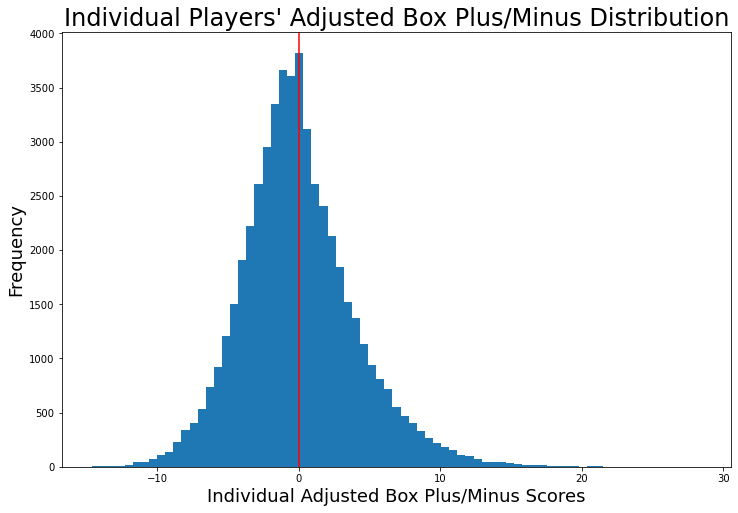

In [627]:
plt.figure(figsize = (12, 8))
plt.hist(df.loc[df["Player"] != "Team Totals", "Adjusted Box Plus/Minus"],
        bins = 75)
plt.axvline(df.loc[df["Player"] != "Team Totals", "Adjusted Box Plus/Minus"].mean(), color = "red")
plt.title("Individual Players' Adjusted Box Plus/Minus Distribution", fontsize = 24)
plt.xlabel("Individual Adjusted Box Plus/Minus Scores", fontsize = 18)
plt.ylabel("Frequency", fontsize = 18);

In [628]:
adjusted_bpm_df = bpm_result(sorted(df["Date"].unique()), "Adjusted Box Plus/Minus")
adjusted_bpm_df.head()

,Season,Date,Home Team,Home Team Average Adjusted BPM,Home Team Summed Adjusted BPM,Home Team Total Points,Away Team,Away Team Average Adjusted BPM,Away Team Summed Adjusted BPM,Away Team Total Points,Home Team Average Adjusted BPM Difference,Home Team Summed Adjusted BPM Difference,Home Team Point Differential,Home Team Result
0,2018,2017-10-17,Cleveland Cavaliers,0.455,4.55,102,Boston Celtics,0.1020,1.02,99,0.3530,3.53,3,W
1,2018,2017-10-17,Golden State Warriors,0.850,10.20,121,Houston Rockets,1.4175,11.34,122,-0.5675,-1.14,-1,L
2,2018,2017-10-18,Boston Celtics,-0.353,-3.53,100,Milwaukee Bucks,0.6070,6.07,108,-0.9600,-9.60,-8,L
3,2018,2017-10-18,Washington Wizards,0.485,4.85,120,Philadelphia 76ers,-0.0930,-0.93,115,0.5780,5.78,5,W
4,2018,2017-10-18,Indiana Pacers,0.207,2.07,140,Brooklyn Nets,-0.7540,-7.54,131,0.9610,9.61,9,W


In [629]:
team_abpm, abpm_metrics = bpm_checker(adjusted_bpm_df, ["Home Team Average Adjusted BPM Difference",
                              "Home Team Summed Adjusted BPM Difference"])
team_abpm

,Wins,Losses
Average Better BPM,1439,1
Average Worse BPM,2,1018
Summed Better BPM,1441,0
Summed Worse BPM,0,1019


In [630]:
abpm_metrics

,Accuracy,Sensitivity,Specificity
Average Score,99.88,99.86,99.9
Summed Score,100.00,100.00,100.0


In [631]:
def my_histogram(column, bins, range = None):
    plt.figure(figsize = (10, 8))

    plt.hist(df.loc[df["Player"] == "Team Totals", column], bins = bins, range = range)
    plt.axvline(df.loc[df["Player"] == "Team Totals", column].mean(), color = "red")
    plt.title("The Distribution of Team " + column, fontsize = 24)
    plt.xlabel("Number of " + column, fontsize = 18)
    plt.ylabel("Frequency", fontsize = 18);

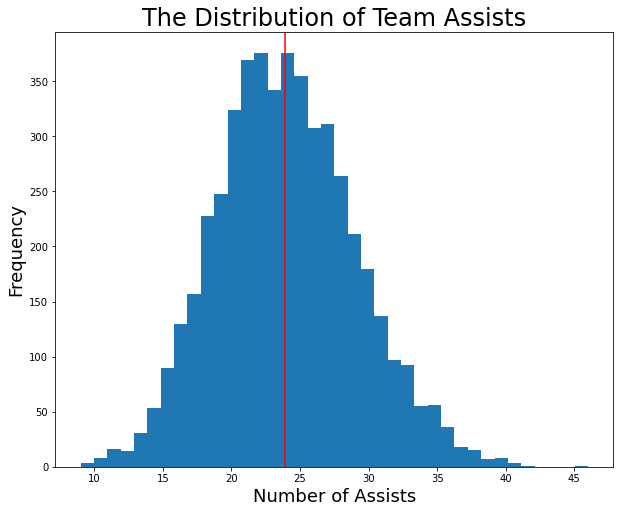

In [632]:
my_histogram("Assists", 38)

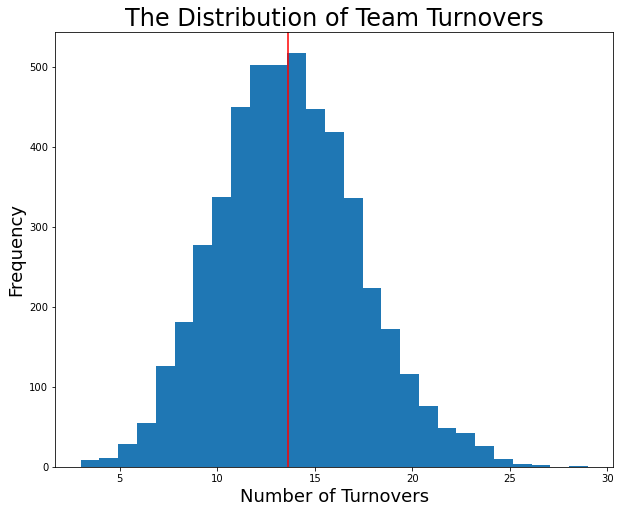

In [633]:
my_histogram("Turnovers", 27)

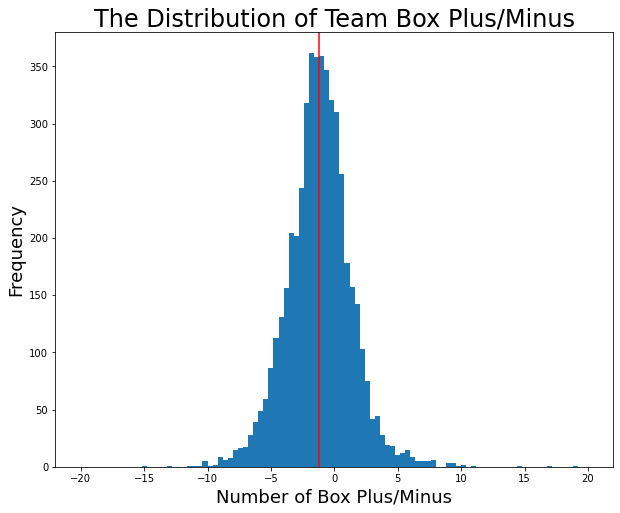

In [634]:
my_histogram("Box Plus/Minus", 100, range = (-20,20))

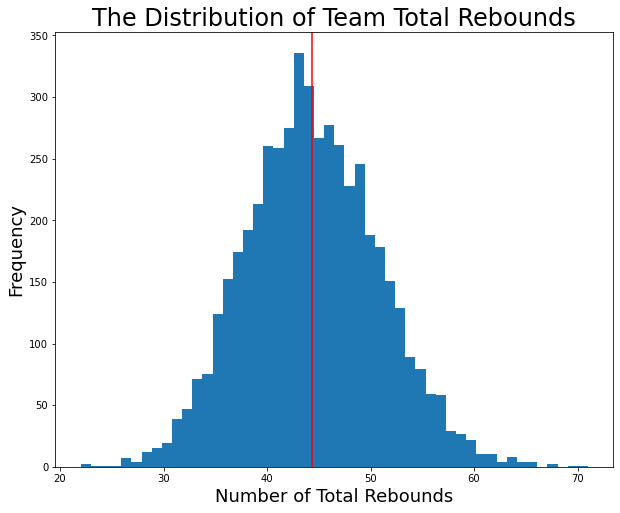

In [635]:
my_histogram("Total Rebounds", 50)

In [636]:
df.head()

,Season,Time Period,Date,Team,Team Abbreviation,Location,Overtime,Result,Player,Minutes Played,Field Goals,Field Goal Attempts,3-Point Field Goals,3-Point Attempts,Free Throws,Free Throw Attempts,Offensive Rebounds,Defensive Rebounds,Total Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,True Shooting Percentage,Effective Field Goal Percentage,3 Point Attempt Rate,Free Throw Attempt Rate,Offensive Rebound Percentage,Defensive Rebound Percentage,Total Rebound Percentage,Assist Percentage,Steal Percentage,Block Percentage,Turnover Percentage,Usage Percentage,Offensive Rating,Defensive Rating,Box Plus/Minus,Adjusted Box Plus/Minus
0,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,DeMar DeRozan,32.05,2,9,0,0,7,8,1,5,6,5,2,1,5,1,11,0.439,0.222,0.000,0.889,3.6,16.3,10.2,20.8,3.0,2.6,28.5,23.4,86.0,97.0,-5.3,-3.54
1,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,Kyle Lowry,31.33,4,7,1,3,3,3,0,4,4,9,1,0,4,1,12,0.721,0.643,0.429,0.429,0.0,13.3,7.0,41.9,1.5,0.0,32.5,16.8,121.0,103.0,2.3,1.50
2,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,Jonas Valančiūnas,30.50,9,17,0,1,5,6,8,7,15,2,2,0,1,4,23,0.586,0.529,0.059,0.353,30.0,23.9,26.8,12.7,3.2,0.0,4.8,28.9,136.0,96.0,4.3,2.73
3,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,Norman Powell,24.58,5,11,3,6,2,2,0,4,4,1,1,0,2,2,15,0.631,0.591,0.545,0.182,0.0,17.0,8.9,6.7,2.0,0.0,14.4,24.1,111.0,101.0,0.0,0.00
4,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,Serge Ibaka,24.23,3,8,2,4,0,0,1,3,4,0,0,2,0,2,8,0.500,0.500,0.500,0.000,4.7,12.9,9.0,0.0,0.0,7.0,0.0,14.1,113.0,101.0,-2.0,-1.01


In [637]:
df.isna().sum()

Season                                0
Time Period                           0
Date                                  0
Team                                  0
Team Abbreviation                     0
Location                              0
Overtime                              0
Result                                0
Player                                0
Minutes Played                        0
Field Goals                           0
Field Goal Attempts                   0
3-Point Field Goals                   0
3-Point Attempts                      0
Free Throws                           0
Free Throw Attempts                   0
Offensive Rebounds                    0
Defensive Rebounds                    0
Total Rebounds                        0
Assists                               0
Steals                                0
Blocks                                0
Turnovers                             0
Personal Fouls                        0
Points                                0


### Offensive Rating vs. Defensive Rating

In [256]:
df.loc[(df["Offensive Rating"] > df["Defensive Rating"]) &
       (df["Player"] == "Team Totals") &
       (df["Result"] == "L"), "Result"].count()

0

In [467]:
df.loc[(df["Offensive Rating"] > df["Defensive Rating"]) &
       (df["Player"] == "Team Totals") &
       (df["Result"] == "W"), "Result"].count()

2460

## Current Game Model Preparation

### Team Totals DataFrame

In [704]:
def rename_values(dataframe, dictionary):
    for k,v in dictionary.items():
        dataframe[k] = dataframe[k].map(v)

In [705]:
result = {
    "W" : 1,
    "L" : 0
}

location = {
    "Home" : 1,
    "Away" : 0
}

columns_and_dicts = {
    "Result"   : result,
    "Location" : location
}

In [719]:
 def game_df(dates, primary_team):
    # Create an empty dataframe to append other dataframes to
    seasons = pd.DataFrame()
    # iterate through all the unique dates in our dataframe
    for date in dates:
        # collect all the indecies of the team totals for all teams that played on that day
        indecies = list(df.loc[(df["Date"] == date) & 
                       (df["Player"] == "Team Totals"), :].index)
        
        # Create Tuples of the 2 teams that played each other on that day and add them to a list.
        teams_played = []
        
        # iterate through all the indecies except the last one
        for i in range(0, len(indecies) -1):
            # Our dataframe goes team by team in order for that team. This means games played on the same day will 
            # typically be separated by thousands of rows. As such, the indecies collected will not be in close
            # proximity to one another, UNLESS those 2 teams were playing each other that day. If they are close
            # together, we add the team names to the list in a Tuple.
            if indecies[i + 1] - indecies[i] < 20:
                teams_played.append((df.loc[indecies[i], "Team"], df.loc[indecies[i + 1], "Team"]))
        
        # iterate through the tuples saved in our list
        for opponents in teams_played:
            team1, team2 = opponents # assign each team a variable.
            
            # check whether team1 was playing at home or away that game
            location_status = list(df.loc[(df["Date"] == date) &
                                  (df["Team"] == team1), :]["Location"])[0]
            
            # reassign our variables to home and away teams
            if location_status == "Home":
                home_team = team1
            else:
                home_team = team2

            if home_team == team1:
                away_team = team2
            else:
                away_team = team1
            
            # This dataframe needs to be collected twice - once with the home team listed first, and once with the
            # away team listed first. This is to avoid the model giving preference to the home team. Now we will assign
            # our variables as the main team or secondary team - which is dependent on whether we want the Home team
            # first or the Away team first.
            if primary_team == "Home":
                main_team = home_team
                secondary_team = away_team
            else:
                main_team = away_team
                secondary_team = home_team
                
            stripped_df = df.drop(columns = ["Time Period", "Team Abbreviation", "Field Goals", "3-Point Field Goals",
                                            "Free Throws", "Total Rebounds", "Points", "Usage Percentage", 
                                            "Offensive Rating", "Defensive Rating", "3 Point Attempt Rate"])
                
            main_df = stripped_df.loc[(stripped_df["Date"] == date) &
                                      (stripped_df["Team"] == main_team) &
                                      (stripped_df["Player"] == "Team Totals"), :].copy()
            
            main_df = main_df.drop(columns = "Player")
            
            rename_values(main_df, columns_and_dicts)
            
            main_df.reset_index(inplace = True, drop = True)

            secondary_df = stripped_df.loc[(stripped_df["Date"] == date) &
                                           (stripped_df["Team"] == secondary_team) &
                                           (stripped_df["Player"] == "Team Totals"), :].copy()
            
            rename_values(secondary_df, columns_and_dicts)
            
            secondary_df = secondary_df.drop(columns = ["Season", "Date", "Result", "Player", "Overtime",
                                                        "Minutes Played"])
            

            
            prefix = "Secondary Team "
            
            for column in list(secondary_df.columns[1:]):
                secondary_df.rename(columns = {
                    column : prefix + column
                }, inplace = True)
                
            secondary_df.rename(columns = {
                "Team" : prefix
            }, inplace = True)
                
            secondary_df.reset_index(inplace = True, drop = True)
            
            game = pd.concat([main_df, secondary_df], axis = 1)
                        
            seasons = seasons.append(game)  
            
        seasons.reset_index(inplace = True, drop = True)
                        
    return seasons

In [825]:
home_teams_current = game_df(df["Date"].unique(), "Home")

away_teams_current = game_df(df["Date"].unique(), "Away")

current_games = pd.concat([home_teams_current, away_teams_current], axis = 0)

current_games.reset_index(inplace = True, drop = True)

current_games = pd.get_dummies(current_games, columns = ["Team", "Secondary Team "], drop_first= True)
current_games.head()

,Season,Date,Location,Overtime,Result,Minutes Played,Field Goal Attempts,3-Point Attempts,Free Throw Attempts,Offensive Rebounds,Defensive Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,True Shooting Percentage,Effective Field Goal Percentage,Free Throw Attempt Rate,Offensive Rebound Percentage,Defensive Rebound Percentage,Total Rebound Percentage,Assist Percentage,Steal Percentage,Block Percentage,Turnover Percentage,Box Plus/Minus,Adjusted Box Plus/Minus,Secondary Team Location,Secondary Team Field Goal Attempts,Secondary Team 3-Point Attempts,Secondary Team Free Throw Attempts,Secondary Team Offensive Rebounds,Secondary Team Defensive Rebounds,Secondary Team Assists,Secondary Team Steals,Secondary Team Blocks,Secondary Team Turnovers,Secondary Team Personal Fouls,Secondary Team True Shooting Percentage,Secondary Team Effective Field Goal Percentage,Secondary Team Free Throw Attempt Rate,Secondary Team Offensive Rebound Percentage,Secondary Team Defensive Rebound Percentage,Secondary Team Total Rebound Percentage,Secondary Team Assist Percentage,Secondary Team Steal Percentage,Secondary Team Block Percentage,Secondary Team Turnover Percentage,Secondary Team Box Plus/Minus,Secondary Team Adjusted Box Plus/Minus,Team_Boston Celtics,Team_Brooklyn Nets,Team_Charlotte Hornets,Team_Chicago Bulls,Team_Cleveland Cavaliers,Team_Dallas Mavericks,Team_Denver Nuggets,Team_Detroit Pistons,Team_Golden State Warriors,Team_Houston Rockets,Team_Indiana Pacers,Team_Los Angeles Clippers,Team_Los Angeles Lakers,Team_Memphis Grizzlies,Team_Miami Heat,Team_Milwaukee Bucks,Team_Minnesota Timberwolves,Team_New Orleans Pelicans,Team_New York Knicks,Team_Oklahoma City Thunder,Team_Orlando Magic,Team_Philadelphia 76ers,Team_Phoenix Suns,Team_Portland Trail Blazers,Team_Sacramento Kings,Team_San Antonio Spurs,Team_Toronto Raptors,Team_Utah Jazz,Team_Washington Wizards,Secondary Team _Boston Celtics,Secondary Team _Brooklyn Nets,Secondary Team _Charlotte Hornets,Secondary Team _Chicago Bulls,Secondary Team _Cleveland Cavaliers,Secondary Team _Dallas Mavericks,Secondary Team _Denver Nuggets,Secondary Team _Detroit Pistons,Secondary Team _Golden State Warriors,Secondary Team _Houston Rockets,Secondary Team _Indiana Pacers,Secondary Team _Los Angeles Clippers,Secondary Team _Los Angeles Lakers,Secondary Team _Memphis Grizzlies,Secondary Team _Miami Heat,Secondary Team _Milwaukee Bucks,Secondary Team _Minnesota Timberwolves,Secondary Team _New Orleans Pelicans,Secondary Team _New York Knicks,Secondary Team _Oklahoma City Thunder,Secondary Team _Orlando Magic,Secondary Team _Philadelphia 76ers,Secondary Team _Phoenix Suns,Secondary Team _Portland Trail Blazers,Secondary Team _Sacramento Kings,Secondary Team _San Antonio Spurs,Secondary Team _Toronto Raptors,Secondary Team _Utah Jazz,Secondary Team _Washington Wizards
0,2018,2017-10-19,1,0.0,1,240.0,83,29,28,13,36,26,10,4,17,19,0.614,0.548,0.337,31.0,78.3,55.7,66.7,10.0,7.0,15.1,0.66,3.30,0,89,32,18,10,29,22,7,2,19,23,0.516,0.472,0.202,21.7,69.0,44.3,59.5,7.0,3.7,16.4,-1.31,-6.55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2018,2017-10-19,1,0.0,1,240.0,90,38,22,13,28,26,14,7,18,22,0.527,0.494,0.244,30.2,71.8,50.0,66.7,14.2,12.7,15.3,1.31,6.55,0,79,24,19,11,30,19,8,4,25,23,0.481,0.449,0.241,28.2,69.8,50.0,59.4,8.1,7.7,22.2,1.37,6.85,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2018,2017-10-19,1,0.0,0,240.0,91,16,23,12,40,21,8,7,19,15,0.455,0.429,0.253,22.2,70.2,46.8,56.8,7.6,9.5,15.8,-1.97,-9.85,0,107,33,13,17,42,23,12,3,14,20,0.479,0.449,0.121,29.8,77.8,53.2,54.8,11.3,4.0,11.0,0.85,4.25,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2018,2017-10-21,1,0.0,1,240.0,89,44,37,8,43,23,5,10,13,29,0.608,0.545,0.416,19.5,84.3,55.4,54.8,4.7,17.2,11.0,3.24,16.20,0,82,24,36,8,33,18,5,4,20,26,0.480,

In [826]:
current_games.shape

(4920, 109)

### Model Workflow
In order to create the best possible model, each model will be produced using the following iterative process.  

- Train/Test Split  

- Establish a baseline.  

- Create a new model using: 
    1. A Pipeline. Each Pipeline will have:
        - A Transformer. In this case, each model will be scaled with Standard Scaler
        - An Estimator (Logistic Regression, Decision Tree, etc.)
    2. Pipeline HyperParameters
        - Each pipeline will have specific Hyperparameters chosen to help make the ideal model.
    3. Advanced Grid Search
        - This will help determine which HyperParameters are the most ideal
    4. An Accuracy Dataframe containing:
        - Training Accuracy
        - Testing Accuracy
        - The Cross Validation Mean
        - Each Cross Validation Accuracy

Each model will be run several times as the HyperParameters are narrowed down to the most ideal.

### Train Test Split

In [830]:
X = current_games.drop(columns = "Result")

y = current_games["Result"]

In [831]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE, train_size = 0.75, stratify = y)

In [832]:
X_train['Date']= X_train['Date'].map(dt.datetime.toordinal)

X_test['Date'] = X_test['Date'].map(dt.datetime.toordinal)

C:\Users\uneck\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\uneck\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Model Evaluator
As far as metrics go, the best option for determining the practicality of each model will be accuracy. We want to see how many games we correctly predicted as wins or losses.

In order to see the accuracy of each test, below is a function that will produce a dataframe that shows us the accuracy scores of the training data, testing data, and cross validations.

In [833]:
# This function was created by me for project 2
def scores_df(model, training_df, testing_df, model_name):
    # Start with a list of our different scores
    list1 = ["Training Accuracy", "Testing Accuracy", "Cross Validation Mean"]
    # create a list with our actual scores
    list2 = [round(model.score(training_df, y_train), 3), 
             round(model.score(testing_df, y_test), 3),
             round(cross_val_score(model, training_df, y_train, cv = 5).mean(), 3)]
    # Loop through all 5 cross validations and return the scores on each one.
    for position, i in enumerate(cross_val_score(model, training_df, y_train, cv = 5)):
        # add our new row name
        list1.append(f"Cross Validation Accuracy, Fold {position + 1}") 
        # add the cross val score
        list2.append(round(i, 3))
        
    # This dataframe initiation was copied from https://www.geeksforgeeks.org/create-a-pandas-dataframe-from-lists/
    df = pd.DataFrame(list(zip(list1, list2)), 
               columns =[model_name, 'Score'])
    return df

## Modeling Current Games

### Baseline Model
Since our problem is a classification problem, it makes sense for our baseline to be compared to the distribution of the wins and losses in any given season. This should be a 50/50 split.

In [834]:
y_train.value_counts(normalize = True)

1    0.5
0    0.5
Name: Result, dtype: float64

In [835]:
y_test.value_counts(normalize = True)

1    0.5
0    0.5
Name: Result, dtype: float64

### Logistic Regression

In [838]:
log_pipe = Pipeline([ 
                ("ss", StandardScaler()),
                ("logreg", LogisticRegression(solver = "saga", max_iter = 10000))
])

pipe_params_log = {
    "ss__with_mean"   : [True],
    "logreg__penalty" : ["l1"],
    "logreg__C"       : [0.25]
}

gs_log = GridSearchCV(log_pipe,
                      pipe_params_log,
                      cv = 5,
                      n_jobs= -1,
                      verbose= 0)

results_log = gs_log.fit(X_train, y_train)
# results_log.best_params_

scores_df(results_log, X_train, X_test, "Logistic Regression Model")

,Logistic Regression Model,Score
0,Training Accuracy,0.995
1,Testing Accuracy,0.988
2,Cross Validation Mean,0.991
3,"Cross Validation Accuracy, Fold 1",0.989
4,"Cross Validation Accuracy, Fold 2",0.986
5,"Cross Validation Accuracy, Fold 3",0.991
6,"Cross Validation Accuracy, Fold 4",0.997
7,"Cross Validation Accuracy, Fold 5",0.991


### Decision Tree

In [839]:
dec_tree_pipe = Pipeline([
                ("ss", StandardScaler()),
                ("dt", DecisionTreeClassifier(random_state = RANDOM_STATE))
])

pipe_params_dt = {
    "ss__with_mean"         : [False],
    "dt__max_depth"         : [10],
    "dt__min_samples_split" : [2],
    "dt__min_samples_leaf"  : [3]
}

gs_dt = GridSearchCV(dec_tree_pipe,
                     pipe_params_dt,
                     cv = 5,
                     n_jobs = -1,
                     verbose = 0)

results_dt = gs_dt.fit(X_train, y_train)

# results_dt.best_params_

scores_df(results_dt, X_train, X_test, "Decision Tree Model")

,Decision Tree Model,Score
0,Training Accuracy,0.965
1,Testing Accuracy,0.824
2,Cross Validation Mean,0.834
3,"Cross Validation Accuracy, Fold 1",0.829
4,"Cross Validation Accuracy, Fold 2",0.833
5,"Cross Validation Accuracy, Fold 3",0.813
6,"Cross Validation Accuracy, Fold 4",0.852
7,"Cross Validation Accuracy, Fold 5",0.843


### Bagging Classifier

In [840]:
bag_pipe = Pipeline([
                ("ss", StandardScaler()),
                ("bag", BaggingClassifier())
])

pipe_params_bag = {
    "ss__with_mean"     : [True],
    "bag__n_estimators" : [600],
    "bag__max_samples"  : [900],
    "bag__max_features" : [25]
}

gs_bag = GridSearchCV(bag_pipe,
                      pipe_params_bag,
                      cv = 5,
                      n_jobs = -1,
                      verbose = 0)

results_bag = gs_bag.fit(X_train, y_train)

# results_bag.best_params_

scores_df(results_bag, X_train, X_test, "Bagged Decision Tree Model")

,Bagged Decision Tree Model,Score
0,Training Accuracy,0.987
1,Testing Accuracy,0.892
2,Cross Validation Mean,0.898
3,"Cross Validation Accuracy, Fold 1",0.883
4,"Cross Validation Accuracy, Fold 2",0.898
5,"Cross Validation Accuracy, Fold 3",0.886
6,"Cross Validation Accuracy, Fold 4",0.902
7,"Cross Validation Accuracy, Fold 5",0.916


### Random Forest Model

In [841]:
rf_pipe = Pipeline([
                ("ss", StandardScaler()),
                ("rf", RandomForestClassifier())
])

pipe_params_rf = {
    "ss__with_mean"         : [False],
    "rf__n_estimators"      : [200],
    "rf__min_samples_split" : [2],
    "rf__min_samples_leaf"  : [1]
}

gs_rf = GridSearchCV(rf_pipe,
                      pipe_params_rf,
                      cv = 5,
                      n_jobs = -1,
                      verbose = 0)

results_rf = gs_rf.fit(X_train, y_train)

# results_rf.best_params_

scores_df(results_rf, X_train, X_test, "Random Forest Model")

,Random Forest Model,Score
0,Training Accuracy,1.000
1,Testing Accuracy,0.896
2,Cross Validation Mean,0.892
3,"Cross Validation Accuracy, Fold 1",0.889
4,"Cross Validation Accuracy, Fold 2",0.897
5,"Cross Validation Accuracy, Fold 3",0.877
6,"Cross Validation Accuracy, Fold 4",0.904
7,"Cross Validation Accuracy, Fold 5",0.908


### ADA Boost

In [842]:
ada_pipe = Pipeline([
                ("ss", StandardScaler()),
                ("ada", AdaBoostClassifier(base_estimator = DecisionTreeClassifier()))
])

pipe_params_ada = {
    "ss__with_mean"         : [True],
    "ada__n_estimators"      : [75],
}

gs_ada = GridSearchCV(ada_pipe,
                      pipe_params_ada,
                      cv = 5,
                      n_jobs = -1,
                      verbose = 0)

results_ada = gs_ada.fit(X_train, y_train)

# results_ada.best_params_

scores_df(results_ada, X_train, X_test, "Ada Boost Model")

,Ada Boost Model,Score
0,Training Accuracy,1.000
1,Testing Accuracy,0.824
2,Cross Validation Mean,0.824
3,"Cross Validation Accuracy, Fold 1",0.820
4,"Cross Validation Accuracy, Fold 2",0.817
5,"Cross Validation Accuracy, Fold 3",0.804
6,"Cross Validation Accuracy, Fold 4",0.841
7,"Cross Validation Accuracy, Fold 5",0.829


## Model Selection

Now that we've created all these different models, let's compare them so we can choose the best one. 

Model Name | Training Accuracy | Testing Accuracy
-|-|-
Baseline | 50% | 50%
Logistic Regression | 99.5% | 98.8%
Decision Tree | 96.5% | 82.4%
Bagged Decision Tree | 98.7% | 89.2%
Random Forest | 100% | 89.6%
Ada Boost Model | 100% | 82.4%

Given the fact that the logistic regression has the least overfitting for the test accuracy, we'll go with that one. 

## Model Evaluation

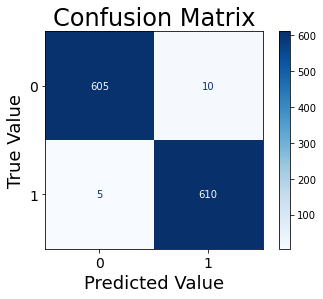

In [924]:
# plot a confusion matrix
plot_confusion_matrix(results_log, X_test, y_test, cmap='Blues', values_format='d')
plt.tick_params(labelsize=14)
plt.title("Confusion Matrix", fontsize = 24)
plt.xlabel("Predicted Value", fontsize = 18)
plt.ylabel("True Value", fontsize = 18);

In [954]:
coef_df = pd.DataFrame(list(zip(X_train.columns, gs_log.best_estimator_.named_steps["logreg"].coef_[0])), 
           columns =["Feature", 'Coefficient'])
coef_df = coef_df.sort_values("Coefficient", ascending = False) # sorting
coef_df = pd.concat([coef_df.iloc[:20, :], coef_df.iloc[-20:, :]])
coef_df


,Feature,Coefficient
15,True Shooting Percentage,8.637222
5,Field Goal Attempts,4.911558
7,Free Throw Attempts,2.232443
47,Secondary Team Turnover Percentage,0.932409
16,Effective Field Goal Percentage,0.454867
37,Secondary Team Personal Fouls,0.261748
20,Total Rebound Percentage,0.249171
19,Defensive Rebound Percentage,0.168163
56,Team_Denver Nuggets,0.135659
84,Secondary Team _Dallas Mavericks,0.127853


In [909]:
limited_coef_df = pd.concat([coef_df.iloc[:5, :], coef_df.iloc[-5:, :]])

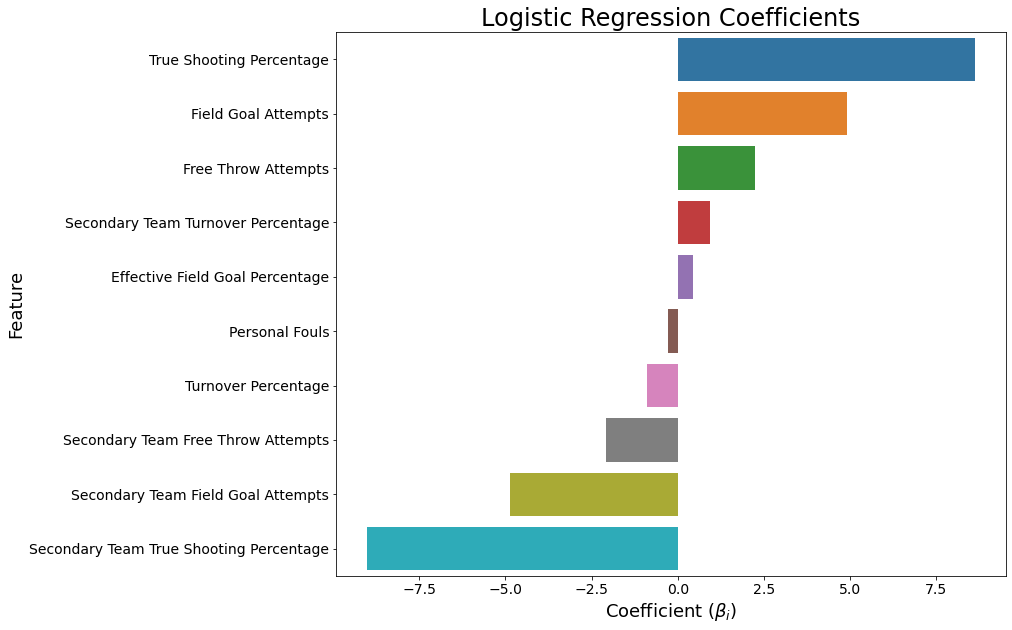

In [910]:
plt.figure(figsize=(12,10))



sns.barplot(data = limited_coef_df, x = "Coefficient", y = "Feature")

plt.title("Logistic Regression Coefficients", fontsize = 24)
plt.xlabel(r"Coefficient $(\beta_i)$", fontsize = 18)
plt.ylabel("Feature", fontsize = 18)
plt.tick_params(labelsize=14);

### Previous Game Model Preparation

In [658]:
# This function was pulled from Mahdi's Linear Time Series Lecture
def multi_lag_appender(dataframe, columns, lags, inplace = False):
    '''Appends the appropriate lag from the list of given lags to the give dataframe'''
    # copying dataframe unless inplace = True
    
    dataframe = dataframe if inplace else dataframe.copy()
    for lag in lags:
        for column in columns:
            dataframe[f"{column}_{lag}"] = dataframe[column].shift(lag)
    
    return None if inplace else dataframe

In [710]:
columns_and_dicts_lag = {
    "Result"     : result,
    "Result_1"   : result,
    "Location"   : location,
    "Location_1" : location
}

In [713]:
def lagged_df(dates, primary_team):
    full_league_lagged_games_df = pd.DataFrame()
    full_league_lagged_df = pd.DataFrame()
    
    for team in list(df["Team"].unique()):
        team_df = df.loc[(df["Team"] == team) &
                         (df["Player"] == "Team Totals"), :].copy()
        
        team_df.sort_values(by = "Date", inplace = True)
        team_df.reset_index(inplace = True, drop = True)
        
        lag_columns = list(df.drop(columns = ["Season", "Time Period", "Team", 
                                              "Team Abbreviation", "Player", ]).columns)
    
    
        team_df_with_lags = multi_lag_appender(team_df, lag_columns, [1])
        team_df_with_lags.drop(index = 0, inplace = True)
        
        full_league_lagged_df = full_league_lagged_df.append(team_df_with_lags)
    
    
    full_league_lagged_df.reset_index(inplace = True, drop = True)
    
    drop_columns = list(df.drop(columns = ["Season","Date", "Team", "Location", "Result"]).columns)
    full_league_lagged_df.drop(columns = drop_columns, inplace = True)
    
# iterate through all the unique dates in our dataframe
    for date in dates:
        # collect all the indecies of the team totals for all teams that played on that day
        indecies = list(df.loc[(df["Date"] == date) & 
                       (df["Player"] == "Team Totals"), :].index)
        
        # Create Tuples of the 2 teams that played each other on that day and add them to a list.
        teams_played = []
        
        # iterate through all the indecies except the last one
        for i in range(0, len(indecies) -1):
            # Our dataframe goes team by team in order for that team. This means games played on the same day will 
            # typically be separated by thousands of rows. As such, the indecies collected will not be in close
            # proximity to one another, UNLESS those 2 teams were playing each other that day. If they are close
            # together, we add the team names to the list in a Tuple.
            if indecies[i + 1] - indecies[i] < 20:
                teams_played.append((df.loc[indecies[i], "Team"], df.loc[indecies[i + 1], "Team"]))
        
        # iterate through the tuples saved in our list
        for opponents in teams_played:
            team1, team2 = opponents # assign each team a variable.
            
            # check whether team1 was playing at home or away that game
            location_status = list(df.loc[(df["Date"] == date) &
                                  (df["Team"] == team1), :]["Location"])[0]
            
            # reassign our variables to home and away teams
            if location_status == "Home":
                home_team = team1
            else:
                home_team = team2

            if home_team == team1:
                away_team = team2
            else:
                away_team = team1
            
            # This dataframe needs to be collected twice - once with the home team listed first, and once with the
            # away team listed first. This is to avoid the model giving preference to the home team. Now we will assign
            # our variables as the main team or secondary team - which is dependent on whether we want the Home team
            # first or the Away team first.
            if primary_team == "Home":
                main_team = home_team
                secondary_team = away_team
            else:
                main_team = away_team
                secondary_team = home_team
                
            main_df = full_league_lagged_df.loc[(full_league_lagged_df["Date"] == date) &
                                                (full_league_lagged_df["Team"] == main_team), :].copy()
            
            rename_values(main_df, columns_and_dicts_lag)
            
            main_df.reset_index(inplace = True, drop = True)
            
            secondary_df = full_league_lagged_df.loc[(full_league_lagged_df["Date"] == date) &
                                                     (full_league_lagged_df["Team"] == secondary_team), :].copy()
            
            rename_values(secondary_df, columns_and_dicts_lag)
            
            secondary_df = secondary_df.drop(columns = ["Season", "Date", "Result"])
            
            prefix = "Secondary Team "
            
            for column in list(secondary_df.columns[1:]):
                secondary_df.rename(columns = {
                    column : prefix + column
                }, inplace = True)
                
            secondary_df.rename(columns = {
                "Team" : prefix
            }, inplace = True)
                
            secondary_df.reset_index(inplace = True, drop = True)
            
            game = pd.concat([main_df, secondary_df], axis = 1)
            
            full_league_lagged_games_df = full_league_lagged_games_df.append(game)
    
    full_league_lagged_games_df.reset_index(inplace = True, drop = True)
    
    return full_league_lagged_games_df

In [884]:
home_teams_lagged = lagged_df(df["Date"].unique(), "Home")
away_teams_lagged = lagged_df(df["Date"].unique(), "Away")

lagged_games = pd.concat([home_teams_lagged, away_teams_lagged], axis = 0)

lagged_games.reset_index(inplace = True, drop = True)

lagged_games = pd.get_dummies(lagged_games, columns = ["Team", "Secondary Team "], drop_first= True)
lagged_games.head()

,Season,Date,Location,Result,Date_1,Location_1,Overtime_1,Result_1,Minutes Played_1,Field Goals_1,Field Goal Attempts_1,3-Point Field Goals_1,3-Point Attempts_1,Free Throws_1,Free Throw Attempts_1,Offensive Rebounds_1,Defensive Rebounds_1,Total Rebounds_1,Assists_1,Steals_1,Blocks_1,Turnovers_1,Personal Fouls_1,Points_1,True Shooting Percentage_1,Effective Field Goal Percentage_1,3 Point Attempt Rate_1,Free Throw Attempt Rate_1,Offensive Rebound Percentage_1,Defensive Rebound Percentage_1,Total Rebound Percentage_1,Assist Percentage_1,Steal Percentage_1,Block Percentage_1,Turnover Percentage_1,Usage Percentage_1,Offensive Rating_1,Defensive Rating_1,Box Plus/Minus_1,Adjusted Box Plus/Minus_1,Secondary Team Location,Secondary Team Date_1,Secondary Team Location_1,Secondary Team Overtime_1,Secondary Team Result_1,Secondary Team Minutes Played_1,Secondary Team Field Goals_1,Secondary Team Field Goal Attempts_1,Secondary Team 3-Point Field Goals_1,Secondary Team 3-Point Attempts_1,Secondary Team Free Throws_1,Secondary Team Free Throw Attempts_1,Secondary Team Offensive Rebounds_1,Secondary Team Defensive Rebounds_1,Secondary Team Total Rebounds_1,Secondary Team Assists_1,Secondary Team Steals_1,Secondary Team Blocks_1,Secondary Team Turnovers_1,Secondary Team Personal Fouls_1,Secondary Team Points_1,Secondary Team True Shooting Percentage_1,Secondary Team Effective Field Goal Percentage_1,Secondary Team 3 Point Attempt Rate_1,Secondary Team Free Throw Attempt Rate_1,Secondary Team Offensive Rebound Percentage_1,Secondary Team Defensive Rebound Percentage_1,Secondary Team Total Rebound Percentage_1,Secondary Team Assist Percentage_1,Secondary Team Steal Percentage_1,Secondary Team Block Percentage_1,Secondary Team Turnover Percentage_1,Secondary Team Usage Percentage_1,Secondary Team Offensive Rating_1,Secondary Team Defensive Rating_1,Secondary Team Box Plus/Minus_1,Secondary Team Adjusted Box Plus/Minus_1,Team_Boston Celtics,Team_Brooklyn Nets,Team_Charlotte Hornets,Team_Chicago Bulls,Team_Cleveland Cavaliers,Team_Dallas Mavericks,Team_Denver Nuggets,Team_Detroit Pistons,Team_Golden State Warriors,Team_Houston Rockets,Team_Indiana Pacers,Team_Los Angeles Clippers,Team_Los Angeles Lakers,Team_Memphis Grizzlies,Team_Miami Heat,Team_Milwaukee Bucks,Team_Minnesota Timberwolves,Team_New Orleans Pelicans,Team_New York Knicks,Team_Oklahoma City Thunder,Team_Orlando Magic,Team_Philadelphia 76ers,Team_Phoenix Suns,Team_Portland Trail Blazers,Team_Sacramento Kings,Team_San Antonio Spurs,Team_Toronto Raptors,Team_Utah Jazz,Team_Washington Wizards,Secondary Team _Boston Celtics,Secondary Team _Brooklyn Nets,Secondary Team _Charlotte Hornets,Secondary Team _Chicago Bulls,Secondary Team _Cleveland Cavaliers,Secondary Team _Dallas Mavericks,Secondary Team _Denver Nuggets,Secondary Team _Detroit Pistons,Secondary Team _Golden State Warriors,Secondary Team _Houston Rockets,Secondary Team _Indiana Pacers,Secondary Team _Los Angeles Clippers,Secondary Team _Los Angeles Lakers,Secondary Team _Memphis Grizzlies,Secondary Team _Miami Heat,Secondary Team _Milwaukee Bucks,Secondary Team _Minnesota Timberwolves,Secondary Team _New Orleans Pelicans,Secondary Team _New York Knicks,Secondary Team _Oklahoma City Thunder,Secondary Team _Orlando Magic,Secondary Team _Philadelphia 76ers,Secondary Team _Phoenix Suns,Secondary Team _Portland Trail Blazers,Secondary Team _Sacramento Kings,Secondary Team _San Antonio Spurs,Secondary Team _Toronto Raptors,Secondary Team _Utah Jazz,Secondary Team _Washington Wizards
0,2018.0,2017-10-21,1.0,1.0,2017-10-19,1.0,0.0,1.0,240.0,39.0,83.0,13.0,29.0,26.0,28.0,13.0,36.0,49.0,26.0,10.0,4.0,17.0,19.0,117.0,0.614,0.548,0.349,0.337,31.0,78.3,55.7,66.7,10.0,7.0,15.1,100.0,117.2,100.1,0.66,3.30,0.0,2017-10-20,1.0,0.0,0.0,240.0,35.0,92.0,10.0,32.0,12.0,16.0,14.0,33.0,47.0,20.0,7.0,4.0,16.0,30.0,92.0,0.464,0.435,0.348,0.174,25.5,70.2,46.1,57.1,7.0,7.3,13.9,100.0,92.4,102.5,-1.60,-8.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [885]:
lagged_games.shape

(4892, 135)

In [886]:
lagged_games["Season"].isna().sum()

2

In [887]:
lagged_games.loc[lagged_games["Date_1"].isna(), :]

,Season,Date,Location,Result,Date_1,Location_1,Overtime_1,Result_1,Minutes Played_1,Field Goals_1,Field Goal Attempts_1,3-Point Field Goals_1,3-Point Attempts_1,Free Throws_1,Free Throw Attempts_1,Offensive Rebounds_1,Defensive Rebounds_1,Total Rebounds_1,Assists_1,Steals_1,Blocks_1,Turnovers_1,Personal Fouls_1,Points_1,True Shooting Percentage_1,Effective Field Goal Percentage_1,3 Point Attempt Rate_1,Free Throw Attempt Rate_1,Offensive Rebound Percentage_1,Defensive Rebound Percentage_1,Total Rebound Percentage_1,Assist Percentage_1,Steal Percentage_1,Block Percentage_1,Turnover Percentage_1,Usage Percentage_1,Offensive Rating_1,Defensive Rating_1,Box Plus/Minus_1,Adjusted Box Plus/Minus_1,Secondary Team Location,Secondary Team Date_1,Secondary Team Location_1,Secondary Team Overtime_1,Secondary Team Result_1,Secondary Team Minutes Played_1,Secondary Team Field Goals_1,Secondary Team Field Goal Attempts_1,Secondary Team 3-Point Field Goals_1,Secondary Team 3-Point Attempts_1,Secondary Team Free Throws_1,Secondary Team Free Throw Attempts_1,Secondary Team Offensive Rebounds_1,Secondary Team Defensive Rebounds_1,Secondary Team Total Rebounds_1,Secondary Team Assists_1,Secondary Team Steals_1,Secondary Team Blocks_1,Secondary Team Turnovers_1,Secondary Team Personal Fouls_1,Secondary Team Points_1,Secondary Team True Shooting Percentage_1,Secondary Team Effective Field Goal Percentage_1,Secondary Team 3 Point Attempt Rate_1,Secondary Team Free Throw Attempt Rate_1,Secondary Team Offensive Rebound Percentage_1,Secondary Team Defensive Rebound Percentage_1,Secondary Team Total Rebound Percentage_1,Secondary Team Assist Percentage_1,Secondary Team Steal Percentage_1,Secondary Team Block Percentage_1,Secondary Team Turnover Percentage_1,Secondary Team Usage Percentage_1,Secondary Team Offensive Rating_1,Secondary Team Defensive Rating_1,Secondary Team Box Plus/Minus_1,Secondary Team Adjusted Box Plus/Minus_1,Team_Boston Celtics,Team_Brooklyn Nets,Team_Charlotte Hornets,Team_Chicago Bulls,Team_Cleveland Cavaliers,Team_Dallas Mavericks,Team_Denver Nuggets,Team_Detroit Pistons,Team_Golden State Warriors,Team_Houston Rockets,Team_Indiana Pacers,Team_Los Angeles Clippers,Team_Los Angeles Lakers,Team_Memphis Grizzlies,Team_Miami Heat,Team_Milwaukee Bucks,Team_Minnesota Timberwolves,Team_New Orleans Pelicans,Team_New York Knicks,Team_Oklahoma City Thunder,Team_Orlando Magic,Team_Philadelphia 76ers,Team_Phoenix Suns,Team_Portland Trail Blazers,Team_Sacramento Kings,Team_San Antonio Spurs,Team_Toronto Raptors,Team_Utah Jazz,Team_Washington Wizards,Secondary Team _Boston Celtics,Secondary Team _Brooklyn Nets,Secondary Team _Charlotte Hornets,Secondary Team _Chicago Bulls,Secondary Team _Cleveland Cavaliers,Secondary Team _Dallas Mavericks,Secondary Team _Denver Nuggets,Secondary Team _Detroit Pistons,Secondary Team _Golden State Warriors,Secondary Team _Houston Rockets,Secondary Team _Indiana Pacers,Secondary Team _Los Angeles Clippers,Secondary Team _Los Angeles Lakers,Secondary Team _Memphis Grizzlies,Secondary Team _Miami Heat,Secondary Team _Milwaukee Bucks,Secondary Team _Minnesota Timberwolves,Secondary Team _New Orleans Pelicans,Secondary Team _New York Knicks,Secondary Team _Oklahoma City Thunder,Secondary Team _Orlando Magic,Secondary Team _Philadelphia 76ers,Secondary Team _Phoenix Suns,Secondary Team _Portland Trail Blazers,Secondary Team _Sacramento Kings,Secondary Team _San Antonio Spurs,Secondary Team _Toronto Raptors,Secondary Team _Utah Jazz,Secondary Team _Washington Wizards
682,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2017-10-17,0.0,0.0,1.0,240.0,47.0,97.0,15.0,41.0,13.0,19.0,10.0,33.0,43.0,28.0,9.0,5.0,12.0,16.0,122.0,0.579,0.562,0.423,0.196,22.2,84.6,51.2,59.6,8.8,10.0,10.2,100.0,119.6,118.6,2.12,10.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0

In [883]:
lagged_games.loc[lagged_games["Secondary Team Date_1"].isna(), :]

,Season,Date,Location,Result,Date_1,Location_1,Overtime_1,Result_1,Minutes Played_1,Field Goals_1,Field Goal Attempts_1,3-Point Field Goals_1,3-Point Attempts_1,Free Throws_1,Free Throw Attempts_1,Offensive Rebounds_1,Defensive Rebounds_1,Total Rebounds_1,Assists_1,Steals_1,Blocks_1,Turnovers_1,Personal Fouls_1,Points_1,True Shooting Percentage_1,Effective Field Goal Percentage_1,3 Point Attempt Rate_1,Free Throw Attempt Rate_1,Offensive Rebound Percentage_1,Defensive Rebound Percentage_1,Total Rebound Percentage_1,Assist Percentage_1,Steal Percentage_1,Block Percentage_1,Turnover Percentage_1,Usage Percentage_1,Offensive Rating_1,Defensive Rating_1,Box Plus/Minus_1,Adjusted Box Plus/Minus_1,Secondary Team Location,Secondary Team Date_1,Secondary Team Location_1,Secondary Team Overtime_1,Secondary Team Result_1,Secondary Team Minutes Played_1,Secondary Team Field Goals_1,Secondary Team Field Goal Attempts_1,Secondary Team 3-Point Field Goals_1,Secondary Team 3-Point Attempts_1,Secondary Team Free Throws_1,Secondary Team Free Throw Attempts_1,Secondary Team Offensive Rebounds_1,Secondary Team Defensive Rebounds_1,Secondary Team Total Rebounds_1,Secondary Team Assists_1,Secondary Team Steals_1,Secondary Team Blocks_1,Secondary Team Turnovers_1,Secondary Team Personal Fouls_1,Secondary Team Points_1,Secondary Team True Shooting Percentage_1,Secondary Team Effective Field Goal Percentage_1,Secondary Team 3 Point Attempt Rate_1,Secondary Team Free Throw Attempt Rate_1,Secondary Team Offensive Rebound Percentage_1,Secondary Team Defensive Rebound Percentage_1,Secondary Team Total Rebound Percentage_1,Secondary Team Assist Percentage_1,Secondary Team Steal Percentage_1,Secondary Team Block Percentage_1,Secondary Team Turnover Percentage_1,Secondary Team Usage Percentage_1,Secondary Team Offensive Rating_1,Secondary Team Defensive Rating_1,Secondary Team Box Plus/Minus_1,Secondary Team Adjusted Box Plus/Minus_1,Team_Boston Celtics,Team_Brooklyn Nets,Team_Charlotte Hornets,Team_Chicago Bulls,Team_Cleveland Cavaliers,Team_Dallas Mavericks,Team_Denver Nuggets,Team_Detroit Pistons,Team_Golden State Warriors,Team_Houston Rockets,Team_Indiana Pacers,Team_Los Angeles Clippers,Team_Los Angeles Lakers,Team_Memphis Grizzlies,Team_Miami Heat,Team_Milwaukee Bucks,Team_Minnesota Timberwolves,Team_New Orleans Pelicans,Team_New York Knicks,Team_Oklahoma City Thunder,Team_Orlando Magic,Team_Philadelphia 76ers,Team_Phoenix Suns,Team_Portland Trail Blazers,Team_Sacramento Kings,Team_San Antonio Spurs,Team_Toronto Raptors,Team_Utah Jazz,Team_Washington Wizards,Secondary Team _Boston Celtics,Secondary Team _Brooklyn Nets,Secondary Team _Charlotte Hornets,Secondary Team _Chicago Bulls,Secondary Team _Cleveland Cavaliers,Secondary Team _Dallas Mavericks,Secondary Team _Denver Nuggets,Secondary Team _Detroit Pistons,Secondary Team _Golden State Warriors,Secondary Team _Houston Rockets,Secondary Team _Indiana Pacers,Secondary Team _Los Angeles Clippers,Secondary Team _Los Angeles Lakers,Secondary Team _Memphis Grizzlies,Secondary Team _Miami Heat,Secondary Team _Milwaukee Bucks,Secondary Team _Minnesota Timberwolves,Secondary Team _New Orleans Pelicans,Secondary Team _New York Knicks,Secondary Team _Oklahoma City Thunder,Secondary Team _Orlando Magic,Secondary Team _Philadelphia 76ers,Secondary Team _Phoenix Suns,Secondary Team _Portland Trail Blazers,Secondary Team _Sacramento Kings,Secondary Team _San Antonio Spurs,Secondary Team _Toronto Raptors,Secondary Team _Utah Jazz,Secondary Team _Washington Wizards
681,2018.0,2017-10-18,1.0,0.0,2017-10-17,0.0,0.0,0.0,240.0,36.0,88.0,8.0,32.0,19.0,25.0,9.0,37.0,46.0,24.0,11.0,4.0,10.0,24.0,99.0,0.500,0.455,0.364,0.284,18.0,80.4,47.9,66.7,11.1,6.6,9.2,100.0,99.7,102.7,-2.72,-13.6,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

__Explanation:__ Nearly every team plays their first game against another team playing in their first game. As such, the first row for each of those teams is dropped, and doesn't make it into the dataframe. However, The Houston Rockets and the Boston Celtics actually played their first games against the two teams that played in the previous year's NBA Finals, then went to play their second game against another team who was playing their first game. So, we have to drop these 4 rows, as they are games where we have no data on their opponents or the main team. 

In [888]:
lagged_games.drop(index = list(lagged_games.loc[lagged_games["Date_1"].isna(), :].index), inplace = True)
lagged_games.drop(index = list(lagged_games.loc[lagged_games["Secondary Team Date_1"].isna(), :].index), inplace = True)
lagged_games.reset_index(inplace = True, drop = True)

### Train Test Split

In [890]:
X_lag = lagged_games.drop(columns = "Result")

y_lag = lagged_games["Result"]

In [892]:
X_train_lag, X_test_lag, y_train_lag, y_test_lag = train_test_split(X_lag, y_lag, 
                                                                    random_state = RANDOM_STATE, 
                                                                    train_size = 0.75, stratify = y_lag)

In [893]:
X_train_lag['Date']   = X_train_lag['Date'].map(dt.datetime.toordinal)
X_train_lag['Date_1'] = X_train_lag['Date_1'].map(dt.datetime.toordinal)
X_train_lag['Secondary Team Date_1'] = X_train_lag['Secondary Team Date_1'].map(dt.datetime.toordinal)

X_test_lag['Date']   = X_test_lag['Date'].map(dt.datetime.toordinal)
X_test_lag['Date_1'] = X_test_lag['Date_1'].map(dt.datetime.toordinal)
X_test_lag['Secondary Team Date_1'] = X_test_lag['Secondary Team Date_1'].map(dt.datetime.toordinal)

C:\Users\uneck\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\uneck\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\uneck\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

### Model Evaluator
We'll continue to use the model evaluator dataframe function that we used for our last models, with a few minor adjustments

In [904]:
def scores_df_lag(model, training_df, testing_df, model_name):
    # Start with a list of our different scores
    list1 = ["Training Accuracy", "Testing Accuracy", "Cross Validation Mean"]
    # create a list with our actual scores
    list2 = [round(model.score(training_df, y_train_lag), 3), 
             round(model.score(testing_df, y_test_lag), 3),
             round(cross_val_score(model, training_df, y_train_lag, cv = 5).mean(), 3)]
    # Loop through all 5 cross validations and return the scores on each one.
    for position, i in enumerate(cross_val_score(model, training_df, y_train_lag, cv = 5)):
        # add our new row name
        list1.append(f"Cross Validation Accuracy, Fold {position + 1}") 
        # add the cross val score
        list2.append(round(i, 3))
        
    # This dataframe initiation was copied from https://www.geeksforgeeks.org/create-a-pandas-dataframe-from-lists/
    df = pd.DataFrame(list(zip(list1, list2)), 
               columns =[model_name, 'Score'])
    return df

## Modeling From Previous Games

### Baseline Model
Since our problem is a classification problem, it makes sense for our baseline to be compared to the distribution of the wins and losses in any given season. This should be about a 50/50 split.

In [894]:
y_train_lag.value_counts(normalize = True)

1.0    0.5
0.0    0.5
Name: Result, dtype: float64

In [895]:
y_test_lag.value_counts(normalize = True)

0.0    0.5
1.0    0.5
Name: Result, dtype: float64

### Logistic Regression

In [905]:
log_pipe_lag = Pipeline([ 
                ("ss", StandardScaler()),
                ("logreg", LogisticRegression(solver = "saga", max_iter = 5000))
])

pipe_params_log_lag = {
    "ss__with_mean"   : [True],
    "logreg__penalty" : ["l1"],
    "logreg__C"       : [0.5]
}

gs_log_lag = GridSearchCV(log_pipe_lag,
                          pipe_params_log_lag,
                          cv = 5,
                          n_jobs= -1,
                          verbose= 0)

results_log_lag = gs_log_lag.fit(X_train_lag, y_train_lag)
# results_log_lag.best_params_

scores_df_lag(results_log_lag, X_train_lag, X_test_lag, "Lagged Logistic Regression Model")

,Lagged Logistic Regression Model,Score
0,Training Accuracy,0.676
1,Testing Accuracy,0.636
2,Cross Validation Mean,0.658
3,"Cross Validation Accuracy, Fold 1",0.650
4,"Cross Validation Accuracy, Fold 2",0.648
5,"Cross Validation Accuracy, Fold 3",0.660
6,"Cross Validation Accuracy, Fold 4",0.660
7,"Cross Validation Accuracy, Fold 5",0.671


### Decision Tree

In [917]:
dec_tree_pipe_lag = Pipeline([
                ("ss", StandardScaler()),
                ("dt", DecisionTreeClassifier(random_state = RANDOM_STATE))
])

pipe_params_dt_lag = {
    "ss__with_mean"         : [False],
    "dt__max_depth"         : [2],
    "dt__min_samples_split" : [2],
    "dt__min_samples_leaf"  : [2]
}

gs_dt_lag = GridSearchCV(dec_tree_pipe_lag,
                         pipe_params_dt_lag,
                         cv = 5,
                         n_jobs = -1,
                         verbose = 0)

results_dt_lag = gs_dt_lag.fit(X_train_lag, y_train_lag)

# results_dt_lag.best_params_

scores_df_lag(results_dt_lag, X_train_lag, X_test_lag, "Lagged Decision Tree Model")

,Lagged Decision Tree Model,Score
0,Training Accuracy,0.593
1,Testing Accuracy,0.562
2,Cross Validation Mean,0.593
3,"Cross Validation Accuracy, Fold 1",0.604
4,"Cross Validation Accuracy, Fold 2",0.602
5,"Cross Validation Accuracy, Fold 3",0.588
6,"Cross Validation Accuracy, Fold 4",0.593
7,"Cross Validation Accuracy, Fold 5",0.580


### Bagging Classifier

In [938]:
bag_pipe_lag = Pipeline([
                ("ss", StandardScaler()),
                ("bag", BaggingClassifier())
])

pipe_params_bag_lag = {
    "ss__with_mean"     : [False],
    "bag__n_estimators" : [1000],
    "bag__max_samples"  : [1100],
    "bag__max_features" : [25]
}

gs_bag_lag = GridSearchCV(bag_pipe_lag,
                          pipe_params_bag_lag,
                          cv = 5,
                          n_jobs = -1,
                          verbose = 0)

results_bag_lag = gs_bag_lag.fit(X_train_lag, y_train_lag)

# results_bag_lag.best_params_

scores_df_lag(results_bag_lag, X_train_lag, X_test_lag, "Lagged Bagged Decision Tree Model")

,Lagged Bagged Decision Tree Model,Score
0,Training Accuracy,1.000
1,Testing Accuracy,0.592
2,Cross Validation Mean,0.604
3,"Cross Validation Accuracy, Fold 1",0.616
4,"Cross Validation Accuracy, Fold 2",0.570
5,"Cross Validation Accuracy, Fold 3",0.636
6,"Cross Validation Accuracy, Fold 4",0.583
7,"Cross Validation Accuracy, Fold 5",0.584


### Random Forest Model

In [949]:
rf_pipe_lag = Pipeline([
                ("ss", StandardScaler()),
                ("rf", RandomForestClassifier())
])

pipe_params_rf_lag = {
    "ss__with_mean"         : [False],
    "rf__n_estimators"      : [165],
    "rf__min_samples_split" : [6],
    "rf__min_samples_leaf"  : [1]
}

gs_rf_lag = GridSearchCV(rf_pipe_lag,
                         pipe_params_rf_lag,
                         cv = 5,
                         n_jobs = -1,
                         verbose = 0)

results_rf_lag = gs_rf_lag.fit(X_train_lag, y_train_lag)

# results_rf_lag.best_params_

scores_df_lag(results_rf_lag, X_train_lag, X_test_lag, "Lagged Random Forest Model")

,Lagged Random Forest Model,Score
0,Training Accuracy,1.000
1,Testing Accuracy,0.601
2,Cross Validation Mean,0.604
3,"Cross Validation Accuracy, Fold 1",0.609
4,"Cross Validation Accuracy, Fold 2",0.578
5,"Cross Validation Accuracy, Fold 3",0.647
6,"Cross Validation Accuracy, Fold 4",0.600
7,"Cross Validation Accuracy, Fold 5",0.599


### ADA Boost

In [953]:
ada_pipe_lag = Pipeline([
                ("ss", StandardScaler()),
                ("ada", AdaBoostClassifier(base_estimator = DecisionTreeClassifier()))
])

pipe_params_ada_lag = {
    "ss__with_mean"     : [True],
    "ada__n_estimators" : [75],
}

gs_ada_lag = GridSearchCV(ada_pipe_lag,
                          pipe_params_ada_lag,
                          cv = 5,
                          n_jobs = -1,
                          verbose = 0)

results_ada_lag = gs_ada_lag.fit(X_train_lag, y_train_lag)

# results_ada_lag.best_params_

scores_df_lag(results_ada_lag, X_train_lag, X_test_lag, "Lagged Ada Boost Model")

,Lagged Ada Boost Model,Score
0,Training Accuracy,1.000
1,Testing Accuracy,0.554
2,Cross Validation Mean,0.537
3,"Cross Validation Accuracy, Fold 1",0.542
4,"Cross Validation Accuracy, Fold 2",0.532
5,"Cross Validation Accuracy, Fold 3",0.517
6,"Cross Validation Accuracy, Fold 4",0.548
7,"Cross Validation Accuracy, Fold 5",0.533


## Model Selection

Now that we've created all these different models, let's compare them so we can choose the best one. 

Model Name | Training Accuracy | Testing Accuracy
-|-|-
Baseline | 50% | 50%
Logistic Regression | 67.6% | 63.6%
Decision Tree | 59.3% | 56.2%
Bagged Decision Tree | 100% | 59.2%
Random Forest | 100% | 60.1%
Ada Boost Model | 100% | 55.4%

Given the fact that the logistic regression has the least overfitting for the test accuracy and the best testing accuracy, we'll go with that one. 

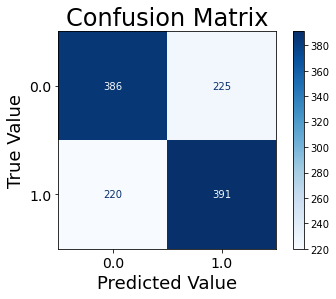

In [925]:
# plot a confusion matrix
plot_confusion_matrix(results_log_lag, X_test_lag, y_test_lag, cmap='Blues', values_format='d')
plt.tick_params(labelsize=14)
plt.title("Confusion Matrix", fontsize = 24)
plt.xlabel("Predicted Value", fontsize = 18)
plt.ylabel("True Value", fontsize = 18);

In [930]:
lag_coef_df = pd.DataFrame(list(zip(X_train_lag.columns, gs_log_lag.best_estimator_.named_steps["logreg"].coef_[0])), 
           columns =["Feature", 'Coefficient'])
lag_coef_df = lag_coef_df.sort_values("Coefficient", ascending = False) # sorting

lag_coef_df

,Feature,Coefficient
85,Team_Houston Rockets,0.279108
102,Team_Toronto Raptors,0.256105
84,Team_Golden State Warriors,0.247730
99,Team_Portland Trail Blazers,0.218780
82,Team_Denver Nuggets,0.214067
2,Location,0.212420
76,Team_Boston Celtics,0.209201
97,Team_Philadelphia 76ers,0.205402
91,Team_Milwaukee Bucks,0.202165
95,Team_Oklahoma City Thunder,0.169931


In [931]:
limited_lag_coef_df = pd.concat([lag_coef_df.iloc[:5, :], lag_coef_df.iloc[-5:, :]])

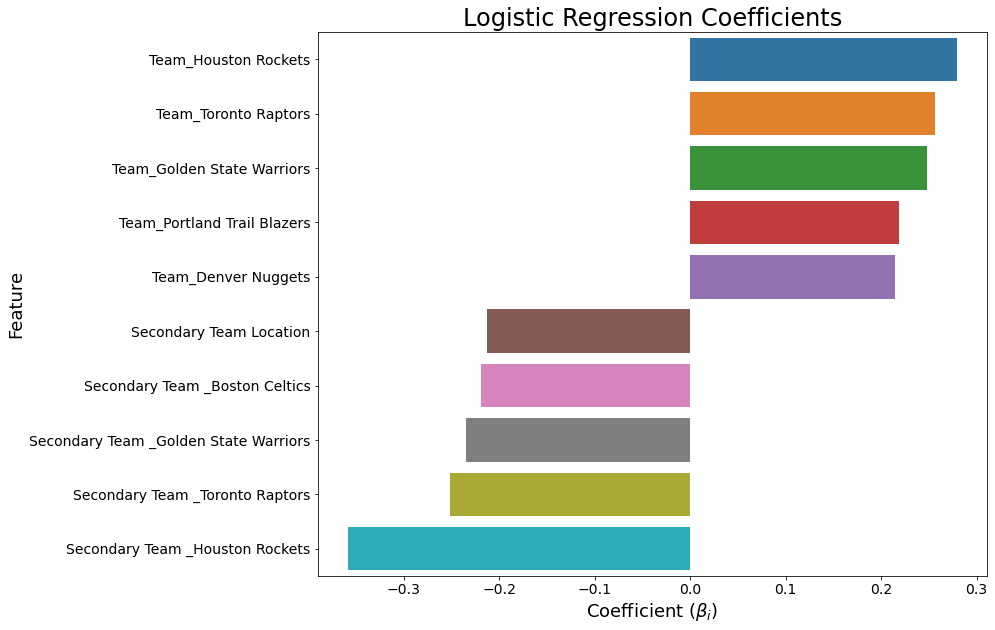

In [932]:
plt.figure(figsize=(12,10))

sns.barplot(data = limited_lag_coef_df, x = "Coefficient", y = "Feature")

plt.title("Logistic Regression Coefficients", fontsize = 24)
plt.xlabel(r"Coefficient $(\beta_i)$", fontsize = 18)
plt.ylabel("Feature", fontsize = 18)
plt.tick_params(labelsize=14);